In [27]:
from matplotlib import colormaps
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Dict
import pandas as pd
import os
import re
import json
import subprocess
import numpy as np
from scipy import stats
from collections import defaultdict, namedtuple
import math as ma
import seaborn as sns
import importlib
from dataclasses import dataclass

import grouping
importlib.reload(grouping)
from grouping import get_groups, ValuesGroup, print_groups, extract_group

#### Global variables

In [2]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"
ABSOLUTE_RESULTS_DIR_PATH = "/home/cgachod/analysis/results"

WORKING_DIR = "/root/tests"
PERF_SCRIPT_RESULTS_FILEPATH = f"{WORKING_DIR}/.perf_mem_results.log"

def in_working_dir(path: str) :
    return os.path.join(WORKING_DIR, path)

In [3]:
CPUID_TO_NODE = {}
matches = re.findall(
    r"NUMA +node\d+ +CPU\(s\): +([\d,]+)", 
    subprocess.run("lscpu", stdout = subprocess.PIPE, universal_newlines = True).stdout
)

NODES_CPUIDS = []

node_id = 0
for cpulist in matches:
    integer_cpulist = [int(cpuid) for cpuid in cpulist.split(',')]
    NODES_CPUIDS.append(integer_cpulist)
    for cpuid in integer_cpulist:
        CPUID_TO_NODE[cpuid] = node_id
    node_id += 1

print(CPUID_TO_NODE)

{0: 0, 2: 0, 4: 0, 6: 0, 8: 0, 10: 0, 12: 0, 14: 0, 16: 0, 18: 0, 20: 0, 22: 0, 24: 0, 26: 0, 28: 0, 30: 0, 32: 0, 34: 0, 36: 0, 38: 0, 40: 0, 42: 0, 44: 0, 46: 0, 48: 0, 50: 0, 52: 0, 54: 0, 56: 0, 58: 0, 60: 0, 62: 0, 1: 1, 3: 1, 5: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1, 17: 1, 19: 1, 21: 1, 23: 1, 25: 1, 27: 1, 29: 1, 31: 1, 33: 1, 35: 1, 37: 1, 39: 1, 41: 1, 43: 1, 45: 1, 47: 1, 49: 1, 51: 1, 53: 1, 55: 1, 57: 1, 59: 1, 61: 1, 63: 1}


In [4]:
PAGE_SIZE = int(subprocess.run(["getconf", "PAGESIZE"], stdout = subprocess.PIPE, universal_newlines = True).stdout)
print(f"Page size : {PAGE_SIZE}")

matches = re.findall(
    r"start_pfn: +(\d+)\sNode (\d+), +zone +(\w+)", 
    subprocess.run(["cat", "/proc/zoneinfo"], stdout = subprocess.PIPE, universal_newlines = True).stdout
)

# page_size = 4096

NODE_UPPER_BOUNDARIES = []
for m in matches:
    if int(m[1]) > len(NODE_UPPER_BOUNDARIES):
        NODE_UPPER_BOUNDARIES.append(int(m[0]) * PAGE_SIZE)
        
print(f"Node upper boundaries : {NODE_UPPER_BOUNDARIES}")


def get_node_for_physical_address(addr: int):
    boundary_idx = 0
    while boundary_idx < len(NODE_UPPER_BOUNDARIES) and addr >= NODE_UPPER_BOUNDARIES[boundary_idx]:
        boundary_idx += 1
    return boundary_idx


Page size : 4096
Node upper boundaries : [104152956928]


In [5]:
LOAD_L3_MISS_REMOTE_FWD_COLOR = "tab:orange"
LOAD_L3_MISS_REMOTE_HITM_COLOR = "tab:pink"
LOAD_L3_MISS_REMOTE_DRAM_COLOR = "r"

In [6]:
def get_shell_command_output(command: str):
    return subprocess.run(
        command,
        shell=True, stdout = subprocess.PIPE, universal_newlines = True
    ).stdout.strip('\n')

In [111]:
@dataclass
class ConfigData:
    access_df: pd.DataFrame
    alloc_df: pd.DataFrame

# def get_initial_timestamp_from_perf_data_file(file_path: str):
#     return float(get_shell_command_output(f"perf script -i {file_path} -F time | head -1").strip(':\n '))

def extract_perf_data_file(file_path: str, force_rerun_extraction = False, executable: Optional[str] = None, time_option: Optional[str] = None):
    sha1sum = get_shell_command_output(f"sha1sum {file_path}")
    print(f"Computed checksum : {sha1sum}")
    extracted_file_path = file_path + ".log"
    
    if not force_rerun_extraction and os.path.isfile(extracted_file_path):
        with open(extracted_file_path, 'r') as f:
            first_line = f.readline().strip("\n")
        if first_line == sha1sum:
            print("Matching checksum found, skipping extraction")
            return extracted_file_path
    
    os.makedirs(os.path.dirname(extracted_file_path), exist_ok=True)
    with open(extracted_file_path, 'w') as f:
        f.write(f"{sha1sum}\n")
        
    executable_filter = f"-c {executable}" if executable is not None else ""
    time_filter = f"--time {time_option}" if time_option is not None else ""
    command_str = f"perf script -i {file_path} -L -F +period {executable_filter} {time_filter} >> {extracted_file_path}"
    print(f"Executing extraction command : {command_str}")
    result = subprocess.run(
        command_str,
        shell=True,
        stdout = subprocess.PIPE,
        universal_newlines = True
    )
    print(f"Output : {result.stdout}")
    
    return extracted_file_path
    
    
def read_kmem_events(extracted_file_path: str):
    # 1: pid, 2: cpu, 3: timestamp, 4: period, 5: event
    kmem_regex = re.compile(r"^ *\S+ +(\d+) +(\d+) +(\d+\.\d+): +(\d+) +(kmem:\S*):")
    
    cpuids = []
    times = []
    periods = []
    events = []
    
    with open(extracted_file_path) as f :
        for line in f :
            matched = kmem_regex.match(line)
            if matched:
                cpuids.append(int(matched[2]))
                times.append(float(matched[3]))
                periods.append(int(matched[4]))
                events.append(matched[5])
                continue
            
    kmem_df = pd.DataFrame({
        "cpuid": cpuids,  
        "time": times, 
        "period": periods,
        "event": events,
    })
    # kmem_df['time'] = kmem_df['time'] - kmem_df['time'].min()
    # kmem_df['cpu_node'] = kmem_df['cpuid'].map(CPUID_TO_NODE)
    # kmem_df['memory_node'] = kmem_df['phys'].map(get_node_for_physical_address)
    return kmem_df
    
    
    
    
    
    
def read_mem_access_and_alloc_events(extracted_file_path: str):
    # 1: pid, 2: cpu, 3: timestamp, 4: period, 5: event, 6: page, 7: pfn, 8: order
    page_alloc_regex = re.compile(r"^ *\S+ +(\d+) +(\d+) +(\d+\.\d+): +(\d+) +(kmem:mm_page_alloc\S*): +page=0x([0-9a-f]+) +pfn=0x([0-9a-f]+) +order=(\d+)")
    # page_alloc_regex = re.compile(r"^ *\S+ +(\d+) +(\d+) +(\d+\.\d+): +(\d+) +(kmem:\S*): +page=0x([0-9a-f]+) +pfn=0x([0-9a-f]+) +order=(\d+)")

    
    # 1: pid, 2: cpuid, 3: timestamp, 4: period, 5: event, 6: virt_addr 
    basic_info_pattern = r"^ *\S+ +(\d+) +(\d+) +(\d+\.\d+): +(\d+) +(\S+): +([0-9a-f]+)"
    
    # 1: cache_result, 2: tlb_result, 3: latency, 4: phys_adress
    data_src_with_latency_pattern = r"[0-9a-f]+ \|OP (?:LOAD|STORE)\|([^\|]+)\|[^\|]+\|(TLB [^\|]+)\|[^\|]+\|[a-zA-Z\/\- ]+(\d+) +\d+ +[0-9a-f]+.+ ([0-9a-f]+)"
    access_with_latency_regex = re.compile(basic_info_pattern + r" +" + data_src_with_latency_pattern)
    
    # # events_df
    # cpuids = []
    # times = []
    # periods = []
    # events = []
    # virtual_addrs = []
    # cache_results = []
    # latencies = []
    # physical_addrs = []
    
    # TODO Add an s to all
    # pid = []
    access_cpuids = []
    access_timestamps = []
    access_periods = []
    access_events = []
    access_virtual_addrs = []
    access_cache_results = []
    access_latencies = []
    access_physical_addrs = []
    
    alloc_cpuids = []
    alloc_times = []
    alloc_events = []
    alloc_pfns = []
    alloc_orders = []
    
    not_matched_lines_count = 0
            
    with open(extracted_file_path) as f :
        for line in f :
            matched = access_with_latency_regex.match(line)
            if matched:
                phys_addr = int(matched[10], base=16)
                if phys_addr == 0:
                    continue
                access_cpuids.append(int(matched[2]))
                access_timestamps.append(float(matched[3]))
                access_periods.append(int(matched[4]))
                access_events.append(matched[5])
                access_virtual_addrs.append(int(matched[6], base=16))
                access_cache_results.append(matched[7])
                access_latencies.append(int(matched[9]))
                access_physical_addrs.append(phys_addr)
                continue
            
            matched = page_alloc_regex.match(line)
            if matched:
                alloc_cpuids.append(int(matched[2]))
                alloc_times.append(float(matched[3]))
                alloc_events.append(matched[5])
                alloc_pfns.append(int(matched[7], base=16))
                alloc_orders.append(int(matched[8]))
                continue
            
            if "kmem:" in line or "syscalls:" in line:
                continue
            
            not_matched_lines_count += 1
    
    print(f"{not_matched_lines_count} lines not matched")
            
    # TODO Rename memory_df ? Because will contain allocations as well ?
    # events_df = pd.DataFrame({
    #     "cpuid": cpuids,  
    #     "time": times, 
    #     "period": periods,
    #     "event": events,
    #     "virt": virtual_addrs,
    #     "cache_result": cache_results,
    #     "latency": latencies,
    #     "phys": physical_addrs, 
    # })
    
    # events_df['time'] = events_df['time'] - events_df['time'].min()
    # events_df['cpu_node'] = events_df['cpuid'].map(CPUID_TO_NODE)
    # events_df['memory_node'] = events_df['phys'].map(get_node_for_physical_address)
    
    access_df = pd.DataFrame({
        "cpuid": access_cpuids,  
        "time": access_timestamps, 
        "period": access_periods,
        "event": access_events,
        "virt": access_virtual_addrs,
        "cache_result": access_cache_results,
        "latency": access_latencies,
        "phys": access_physical_addrs, 
    })
    
    alloc_df = pd.DataFrame({
        'cpuid': alloc_cpuids,
        'time': alloc_times,
        'event': alloc_events,
        'pfn': alloc_pfns,
        'order': alloc_orders
    })
    
    print(f"min access df : {access_df['time'].min()}")
    print(f"min alloc df : {alloc_df['time'].min()}")
    initial_timestamp = min(access_df['time'].min(), alloc_df['time'].min())
    print(f"min of the two : {initial_timestamp}")
    access_df['time'] = access_df['time'] - initial_timestamp
    alloc_df['time'] = alloc_df['time'] - initial_timestamp
    
    access_df['cpu_node'] = access_df['cpuid'].map(CPUID_TO_NODE)
    access_df['memory_node'] = access_df['phys'].map(get_node_for_physical_address)
    alloc_df['cpu_node'] = alloc_df['cpuid'].map(CPUID_TO_NODE)
    alloc_df['memory_node'] = alloc_df['pfn'].map(lambda x: get_node_for_physical_address(x * PAGE_SIZE))
    
    
    
    # I guess what I could just do here is convert the allocation to their base address ?
    return ConfigData(access_df, alloc_df)
    
    
def process_perf_data_file(file_path: str, force_rerun_extraction = False, executable = "cg.C.x", time_option = None):
    extracted_file_path = extract_perf_data_file(file_path, force_rerun_extraction, executable, time_option)
    return read_mem_access_and_alloc_events(extracted_file_path)
    
def read_memory_events():
    pass

In [15]:
hex(20828913664)

'0x4d9800000'

In [16]:
hex(512)

'0x200'

In [9]:
extracted_file_path = extract_perf_data_file(in_working_dir("perf-mem-all-sequential.data"), force_rerun_extraction=True, executable="cg.C.x")

Computed checksum : bda92cad664b17c9c9cb676a152ce950951de06b  /root/tests/perf-mem-all-sequential.data
Executing extraction command : perf script -i /root/tests/perf-mem-all-sequential.data -L -F +period -c cg.C.x  >> /root/tests/perf-mem-all-sequential.data.log


libtraceevent: No such file or directory
  [kmem:mm_page_alloc_extfrag] function __builtin_choose_expr not defined
Processed 33248793 events and lost 299 chunks!

Check IO/CPU overload!

Processed 34924746 samples and lost 5.29%!

5658210 out of order events recorded.


Output : 


In [18]:
kmem_df = read_kmem_events(extracted_file_path)

In [20]:
kmem_df['event'].value_counts()

event
kmem:mm_page_alloc_zone_locked    8818
kmem:kmem_cache_free              7023
kmem:rss_stat                     4706
kmem:mm_page_free                 3997
kmem:mm_page_alloc                3782
kmem:mm_page_free_batched         3057
kmem:mm_page_pcpu_drain           1733
kmem:kmem_cache_alloc             1260
kmem:kfree                        1059
kmem:kmalloc                       567
Name: count, dtype: int64

In [30]:
config_data = read_mem_access_and_alloc_events(in_working_dir(".perf.sample.log"))
# test_one.sort_values('time')

# test_one.iloc[1134]
# config_data.alloc_df['order'].value_counts()

1 lines not matched


order
0    1683
3      27
9      10
Name: count, dtype: int64

In [112]:
seq_data = process_perf_data_file(in_working_dir("perf-mem-all-sequential.data")) 

Computed checksum : bda92cad664b17c9c9cb676a152ce950951de06b  /root/tests/perf-mem-all-sequential.data
Matching checksum found, skipping extraction
1 lines not matched
min access df : 13453.998016
min alloc df : 13453.99938
min of the two : 13453.998016


In [47]:
seq_data.access_df.sort_values("time")

cpuid       time  period                                   event  \
2            49   0.000000     100  mem_load_l3_miss_retired.remote_dram:P   
0            49   0.000003     100   mem_load_l3_miss_retired.local_dram:P   
1            49   0.000238     100   mem_load_l3_miss_retired.local_dram:P   
3            49   0.000423     100  mem_load_l3_miss_retired.remote_dram:P   
4            49   0.000635     100   mem_load_l3_miss_retired.local_dram:P   
...         ...        ...     ...                                     ...   
22052015     36  17.465533     800             cpu/mem-stores,period=800/P   
22052016     36  17.465538     800             cpu/mem-stores,period=800/P   
22052017     36  17.465548     800             cpu/mem-stores,period=800/P   
22052018     36  17.465559     800             cpu/mem-stores,period=800/P   
22052019     36  17.466247     100  mem_load_l3_miss_retired.remote_dram:P   

                          virt        cache_result  latency          phys  \
2         18446744072395002744      LVL N/A or N/A        0   88695214968   
0         18446613555140744072      LVL N/A or N/A        0  104271565704   
1         18446613555614204480      LVL N/A or N/A        0  104745026112   
3         18446613455613162296      LVL N/A or N/A        0    4743983928   
4         18446613555643250824      LVL N/A or N/A        0  104774072456   
...                        ...                 ...      ...           ...   
22052015  18446613553426920320   LVL L1 or N/A hit        0  102557741952   
22052016  18446613459396692128   LVL L1 or N/A hit        0    8527513760   
22052017  18446613459396694256   LVL L1 or N/A hit        0    8527515888   
22052018  18446613459396696640  LVL L1 or N/A miss        0    8527518272   
22052019  18446613658101076792      LVL N/A or N/A        0  207231898424   

          cpu_node  memory_node  
2                1            0  
0                1            1  
1                1            1  
3                1            0  
4                1            1  
...            ...          ...  
22052015         0            0  
22052016         0            0  
22052017         0            0  
22052018         0            0  
22052019         0            1  

[22052020 rows x 10 columns]

- Useless to sort by latency because only loads and stores event have them

## Analyzing cpu loads and remote l3 misses

Plot number of l3 remote cache for each CPU. Possibly can be multiplied by the period value

### Filters

In [32]:
def filter_in_bounds(df: pd.DataFrame, bounds: tuple, variable: str):
    if bounds[1] is None:
        return df.loc[df[variable] >= bounds[0]]
    if bounds[0] is None:
        return df.loc[df[variable] < bounds[1]]
    return df.loc[(df[variable] >= bounds[0]) & (df[variable] < bounds[1])]

def filter_local_access(df: pd.DataFrame):
    return df.loc[df['cpu_node'] == df['memory_node']]

def filter_remote_access(df: pd.DataFrame):
    return df.loc[df['cpu_node'] != df['memory_node']]

def filter_loads_stores(df: pd.DataFrame):
    return df.loc[df['event'].str.contains("cpu/")]

def local_access_proportion(df: pd.DataFrame):
    # (sock_df['cpu_node'] == sock_df['memory_node']).astype(int) * sock_df['period']
    return 100 * sum((df['cpu_node'] == df['memory_node']).astype(int) * df['period']) / sum(df['period'])

In [33]:
MemoryEventNames = namedtuple("MemoryEventNames", ["loads", "stores", "load_l3_miss_local_dram", "load_l3_miss_remote_dram", "load_l3_miss_remote_fwd", "load_l3_miss_remote_hitm"])

# Have to be in the same order as MemoryEventNames
search_patterns = ["cpu/mem-loads", "cpu/mem-stores", "mem_load_l3_miss_retired.local_dram", "mem_load_l3_miss_retired.remote_dram", "mem_load_l3_miss_retired.remote_fwd", "mem_load_l3_miss_retired.remote_hitm"]

def get_memory_event_names(df: pd.DataFrame) -> MemoryEventNames:
    events_list = df['event'].unique()
    event_names = []
    for sp in search_patterns:
        actual_name = None
        for event in events_list:
            if sp in event:
                actual_name = event
                # event_names.append(event)
                break
        event_names.append(actual_name)
            
    return MemoryEventNames(*event_names)

In [44]:
MEM_EVENTS = get_memory_event_names(seq_data.access_df)

### Remote vs local stats

In [10]:
def print_locality_stats(df: pd.DataFrame):
    # local_df = filter_local_access(df)
    # remote_df = filter_remote_access(df)
    
    ev_names = get_memory_event_names(seq_df)

    # TODO Interesting to compare percentage of remote nodes on different pinning modes.
    print(f"Total number of memory access events : {'{:.6e}'.format(len(df))}")
    print(f"Percentage of local loads/stores events : {local_access_proportion(filter_loads_stores(df))}")
    print(f"Percentage of local events : {local_access_proportion(df)}")
    # remote_df = events_df.loc[events_df['cpu_node'] != events_df['memory_node']]
    # remote_df['event'].value_counts()

    local_dram_subset = df.loc[df['event'] == ev_names.load_l3_miss_local_dram]
    remote_dram_subset = df.loc[df['event'] == ev_names.load_l3_miss_remote_dram]
    fwd_subset = df.loc[df['event'] == ev_names.load_l3_miss_remote_fwd]
    hitm_subset = df.loc[df['event'] == ev_names.load_l3_miss_remote_hitm]

    print(f"Percentage of {ev_names.load_l3_miss_local_dram} events where memory is local : {local_access_proportion(local_dram_subset)}")
    print(f"Percentage of {ev_names.load_l3_miss_remote_dram} events where memory is local : {local_access_proportion(remote_dram_subset)}")
    print(f"Percentage of {ev_names.load_l3_miss_remote_fwd} events where memory is local : {local_access_proportion(fwd_subset)}")
    print(f"Percentage of {ev_names.load_l3_miss_remote_hitm} events where memory is local : {local_access_proportion(hitm_subset)}")

In [11]:
# Can we cache a remote dram address ?

print_locality_stats(sock_df)

print_locality_stats(seq_df)

# remote_df.loc[~remote_df['event'].isin(np.array(["cpu/mem-stores/P", "cpu/mem-loads/P"]))]

Total number of events : 4.669329e+06
Percentage of local loads/stores events : 89.68690439302271
Percentage of local events : 89.1898317954126
Percentage of mem_load_l3_miss_retired.remote_fwd:P events where memory is local : 68.13051379409681
Percentage of mem_load_l3_miss_retired.remote_hitm:P events where memory is local : 0.4204547550113412
Percentage of mem_load_l3_miss_retired.remote_dram:P events where memory is local : 0.2850989001841697
Total number of events : 1.355123e+07
Percentage of local loads/stores events : 65.06947474242598
Percentage of local events : 60.99988898092088
Percentage of mem_load_l3_miss_retired.remote_fwd:P events where memory is local : 63.40296553363016
Percentage of mem_load_l3_miss_retired.remote_hitm:P events where memory is local : 10.515091023869239
Percentage of mem_load_l3_miss_retired.remote_dram:P events where memory is local : 0.10412233175529911


Kinda wanna have a graph of locality of memory acccess over time

In [29]:
def plot_access_locality_over_time(dfs: List[pd.DataFrame], labels: list[str], min_t: Optional[float] = None, max_t: Optional[float] = None, bins = 500):
    if len(dfs) != len(labels):
        raise Exception("label and dfs parameters need to have the same length")
    
    overall_min_t = min([df['time'].min() for df in dfs])
    overall_max_t = max([df['time'].max() for df in dfs])
    should_filter = min_t is not None or max_t is not None
    if min_t is None:
        min_t = overall_min_t
    if max_t is None:
        max_t = overall_max_t
    if should_filter:
        dfs = [filter_in_bounds(df, (min_t, max_t), "time") for df in dfs]
    
    intervals = np.linspace(min_t, max_t, bins + 1)
    interval_width = intervals[1] - intervals[0]
    
    agg_locality = []
    agg_count = []
    agg_interval = []
    
    for df in dfs:
        local_percents = []
        bin_count = []
        curr_intervals = []
        for i in range(len(intervals) - 1):
            curr_df = df.loc[(df['time'] >= intervals[i]) & (df['time'] < intervals[i + 1])]
            if len(curr_df) == 0:
                continue
            local_percents.append(local_access_proportion(curr_df))
            bin_count.append(len(curr_df))
            curr_intervals.append(intervals[i])
        agg_locality.append(local_percents)
        agg_count.append(bin_count)
        agg_interval.append(curr_intervals)

    plt.minorticks_on()
    plt.gcf().set_size_inches(15, 7)
    plt.grid(which="both", axis="y")
    plt.ylim(bottom = 0, top = 100)
    for loc, inter, label in zip(agg_locality, agg_interval, labels):
        plt.plot(inter, loc, label=label)
    plt.title(f"Proportion of local / total memory accesses, aggregated every {'{:.3f}'.format(interval_width * 1000)} ms")
    plt.legend(loc="best")
    plt.show()

    # plt.minorticks_on()
    # plt.gcf().set_size_inches(15, 7)
    # plt.grid(which="both", axis="y")
    # plt.plot(intervals[:-1], sums)
    # plt.show()
    
            
    

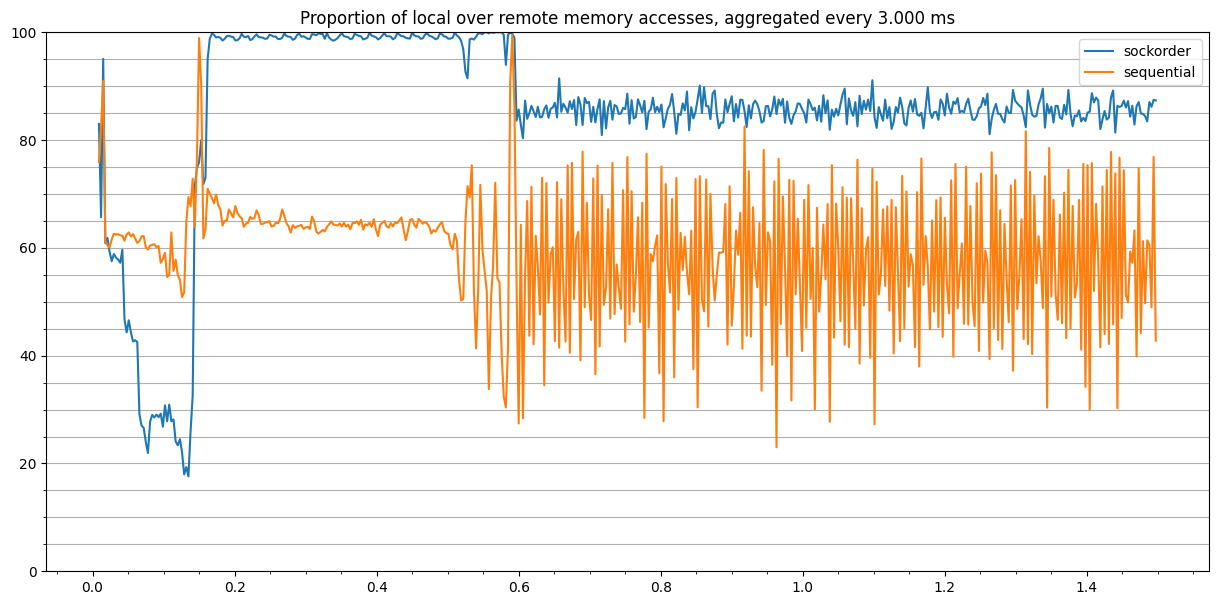

In [28]:
plot_access_locality_over_time([sock_df, seq_df], ["sockorder", "sequential"], min_t=0.0, max_t=1.5)

In [43]:
def plot_event_over_time(dfs: List[pd.DataFrame], labels: List[str], event: str, cpuids: Optional[List[int]] = None, min_t: Optional[float] = None, max_t: Optional[float] = None, bins = 500, w = 15, h = 7):
    if len(dfs) != len(labels):
        raise Exception("dfs and labels parameters need to have the same length")
    
    if cpuids:
        dfs = [df.loc[df['cpuid'].isin(cpuids)] for df in dfs]
    
    overall_min_t = min([df['time'].min() for df in dfs])
    overall_max_t = max([df['time'].max() for df in dfs])
    should_filter = min_t is not None or max_t is not None
    if min_t is None:
        min_t = overall_min_t
    if max_t is None:
        max_t = overall_max_t
    if should_filter:
        dfs = [filter_in_bounds(df, (min_t, max_t), "time") for df in dfs]
    dfs = [df.loc[df['event'] == event] for df in dfs]
    
    intervals = np.linspace(min_t, max_t, bins + 1)
    interval_width = intervals[1] - intervals[0]
    
    agg_count = []
    
    for df in dfs:
        counts = []
        for i in range(len(intervals) - 1):
            curr_count = filter_in_bounds(df, (intervals[i], intervals[i + 1]), "time")['period'].sum()
            counts.append(curr_count)
        agg_count.append(counts)

    plt.minorticks_on()
    plt.gcf().set_size_inches(w, h)
    plt.grid(which="both", axis="y")
    plt.grid(which="major", axis="x")
    # plt.ylim(bottom = 0, top = 100)
    for counts, label in zip(agg_count, labels):
        plt.plot(intervals[:-1], counts, label=label)
    plt.xticks(np.linspace(min_t, max_t, int(w * 1.5)), rotation=20, ha='right')
    plt.title(f"Number of {event}, aggregated every {'{:.3f}'.format(interval_width * 1000)} ms")
    plt.legend(loc="best")
    plt.show()

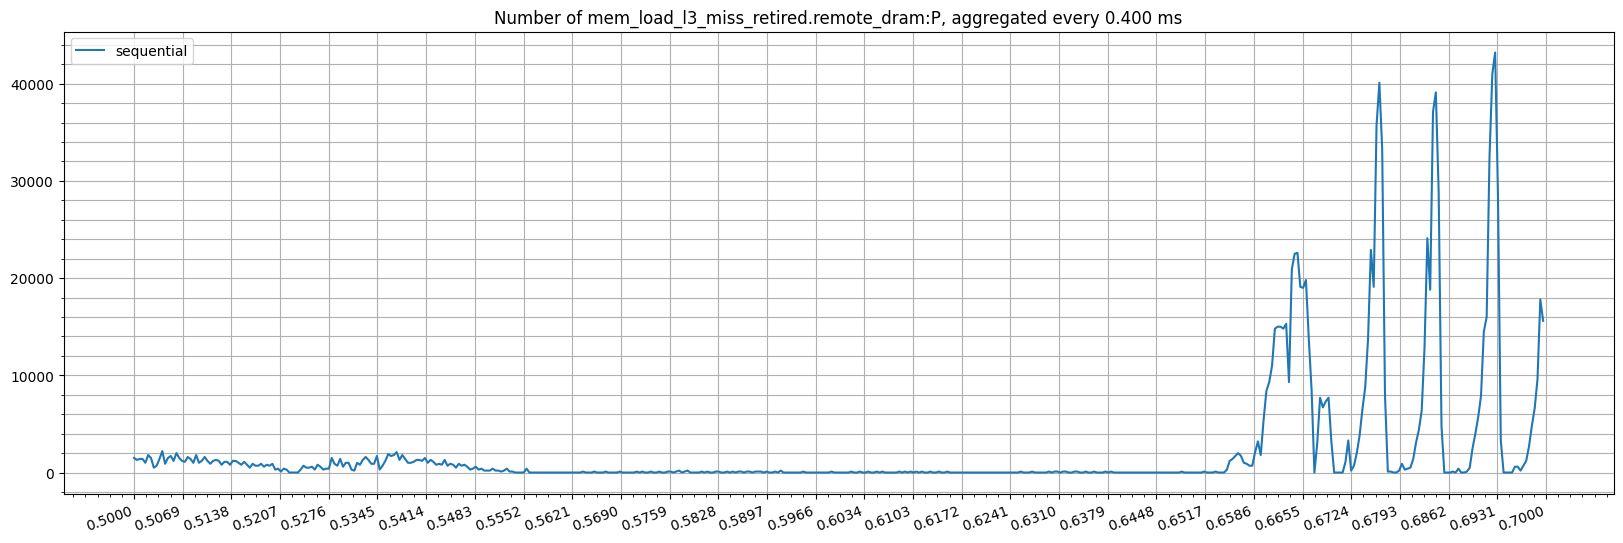

In [52]:
# plot_event_over_time([seq_df, sock_df], ["sequential", "sockorder"], cpuids = [25], event=MEM_EVENTS.load_l3_miss_remote_dram, bins=500, min_t=0.5, max_t=0.7, w=20, h=6)
plot_event_over_time([seq_data.access_df], ["sequential"], MEM_EVENTS.load_l3_miss_remote_dram, bins=500, min_t=0.5, max_t=0.7, w=20, h=6)

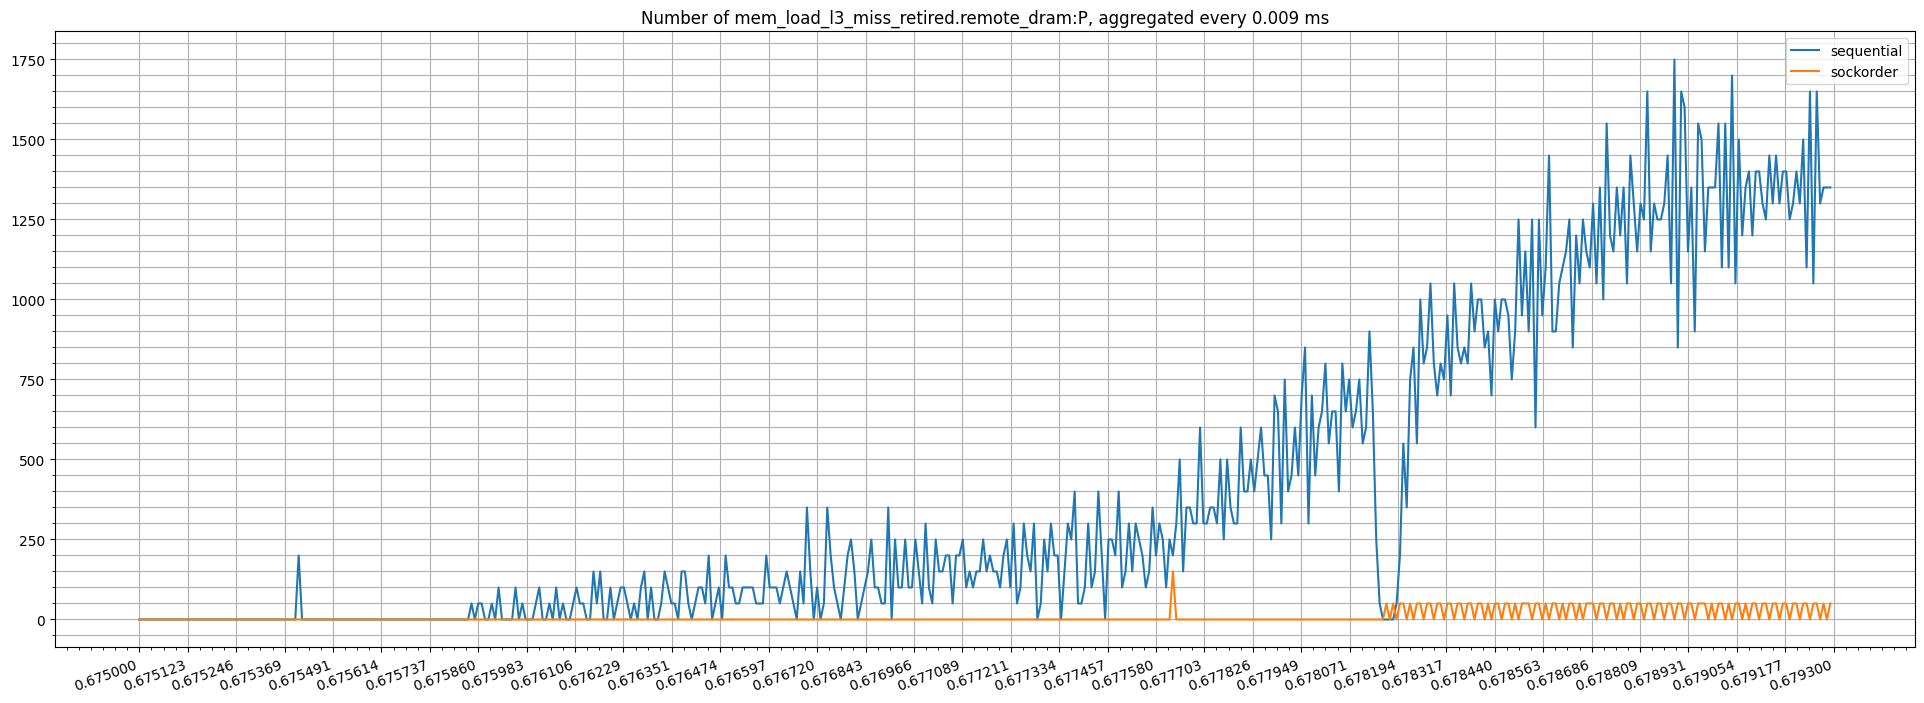

In [143]:
plot_event_over_time([seq_data.access_df], ["sequential"], MEM_EVENTS.load_l3_miss_remote_dram, bins=500, min_t=0.6783, max_t=0.6724, w=24, h=8)
# plot_event_over_time([seq_df, sock_df], ["sequential", "sockorder"], LOAD_L3_MISS_REMOTE_DRAM, bins=500, min_t=0.6783, max_t=0.6862, w=24, h=8)

In [34]:
TIME_START = 0.678931
TIME_END = 0.679054

### Event counts per CPU

In [35]:
def plot_event_count_per_cpu(dfs: List[pd.DataFrame], names: List[str], event: str) :
    dfs = [df.loc[df['event'] == event] for df in dfs]
    dfs = [df.groupby('cpuid')['period'].sum().reset_index() for df in dfs]
    
    for df, name in zip(dfs, names):
        df['source'] = name
        
    combined_df = pd.concat(dfs)
        
    plt.figure(figsize=(30, 10))
    sns.barplot(x='cpuid', y='period', hue='source', data=combined_df)

    # Add labels and title
    plt.xlabel('CPU')
    plt.ylabel('Number of events')
    plt.title(f"Count of {event} per CPU")
    plt.show()
    

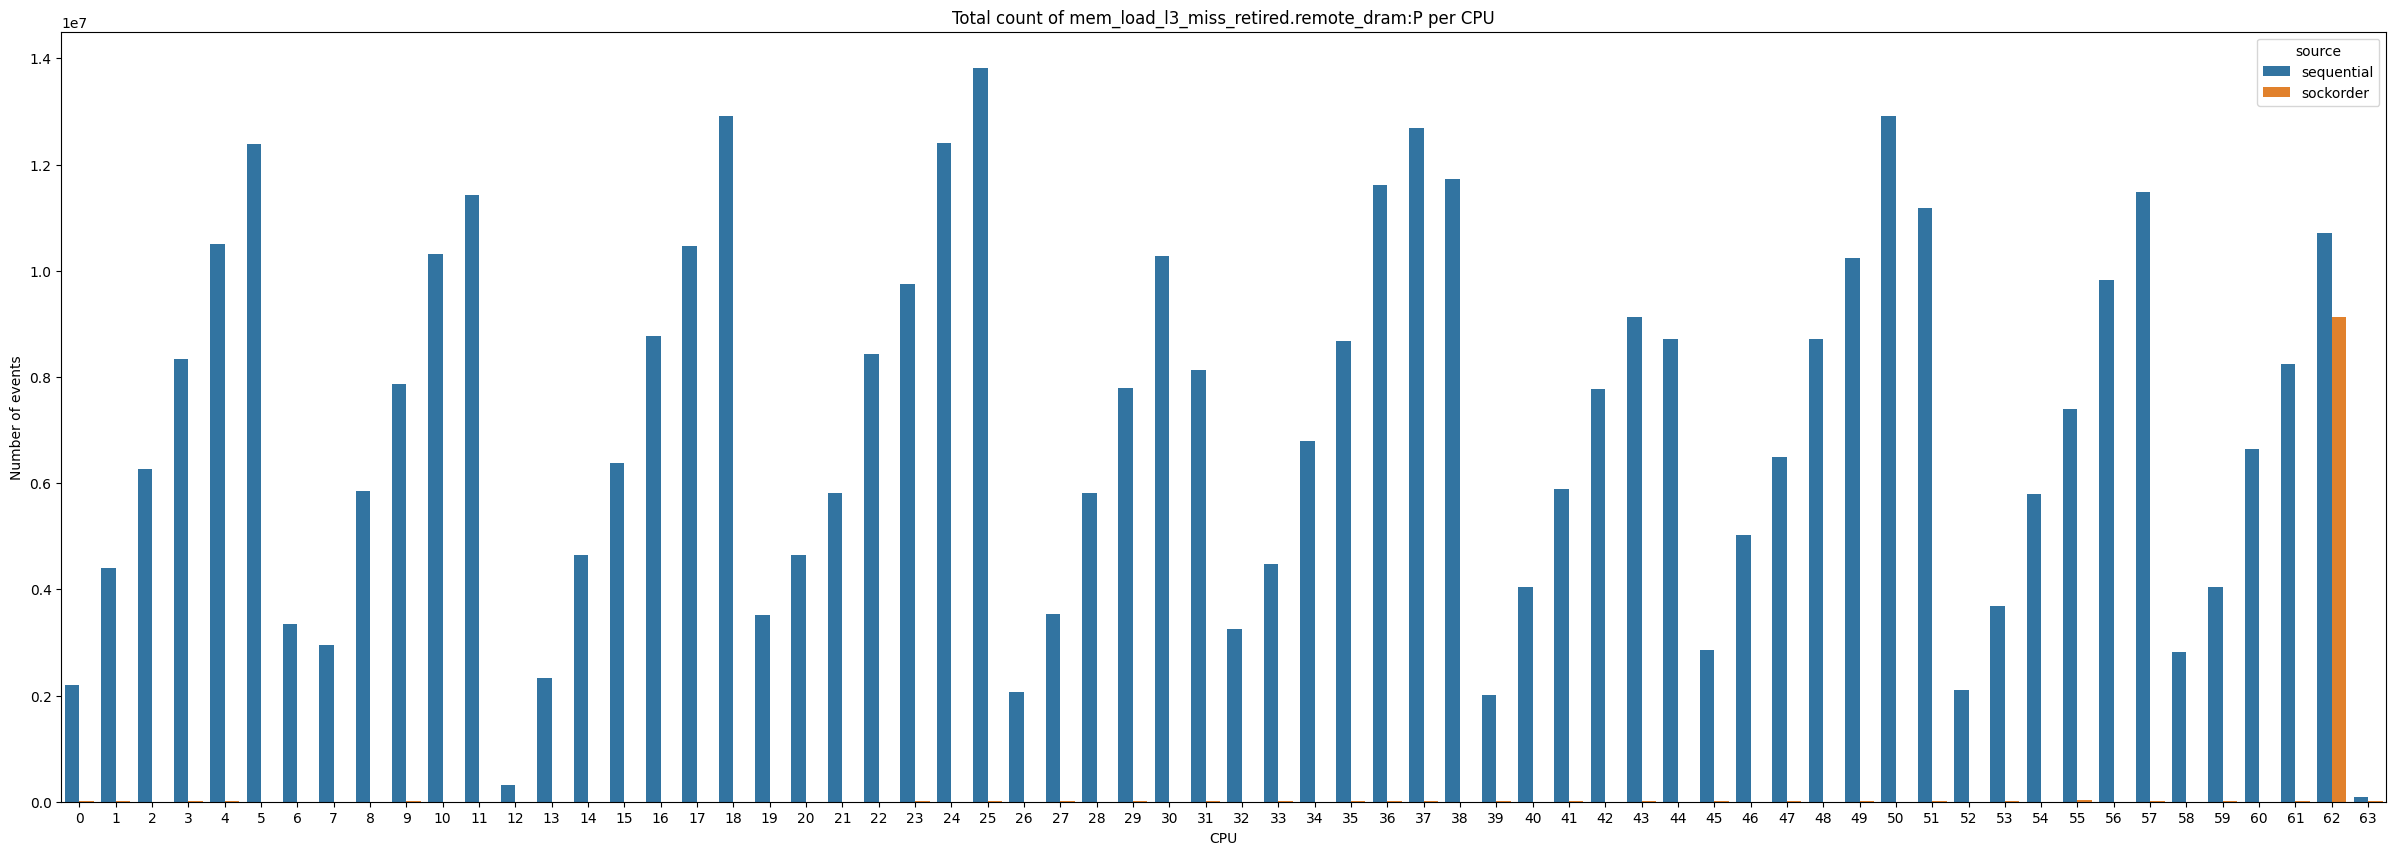

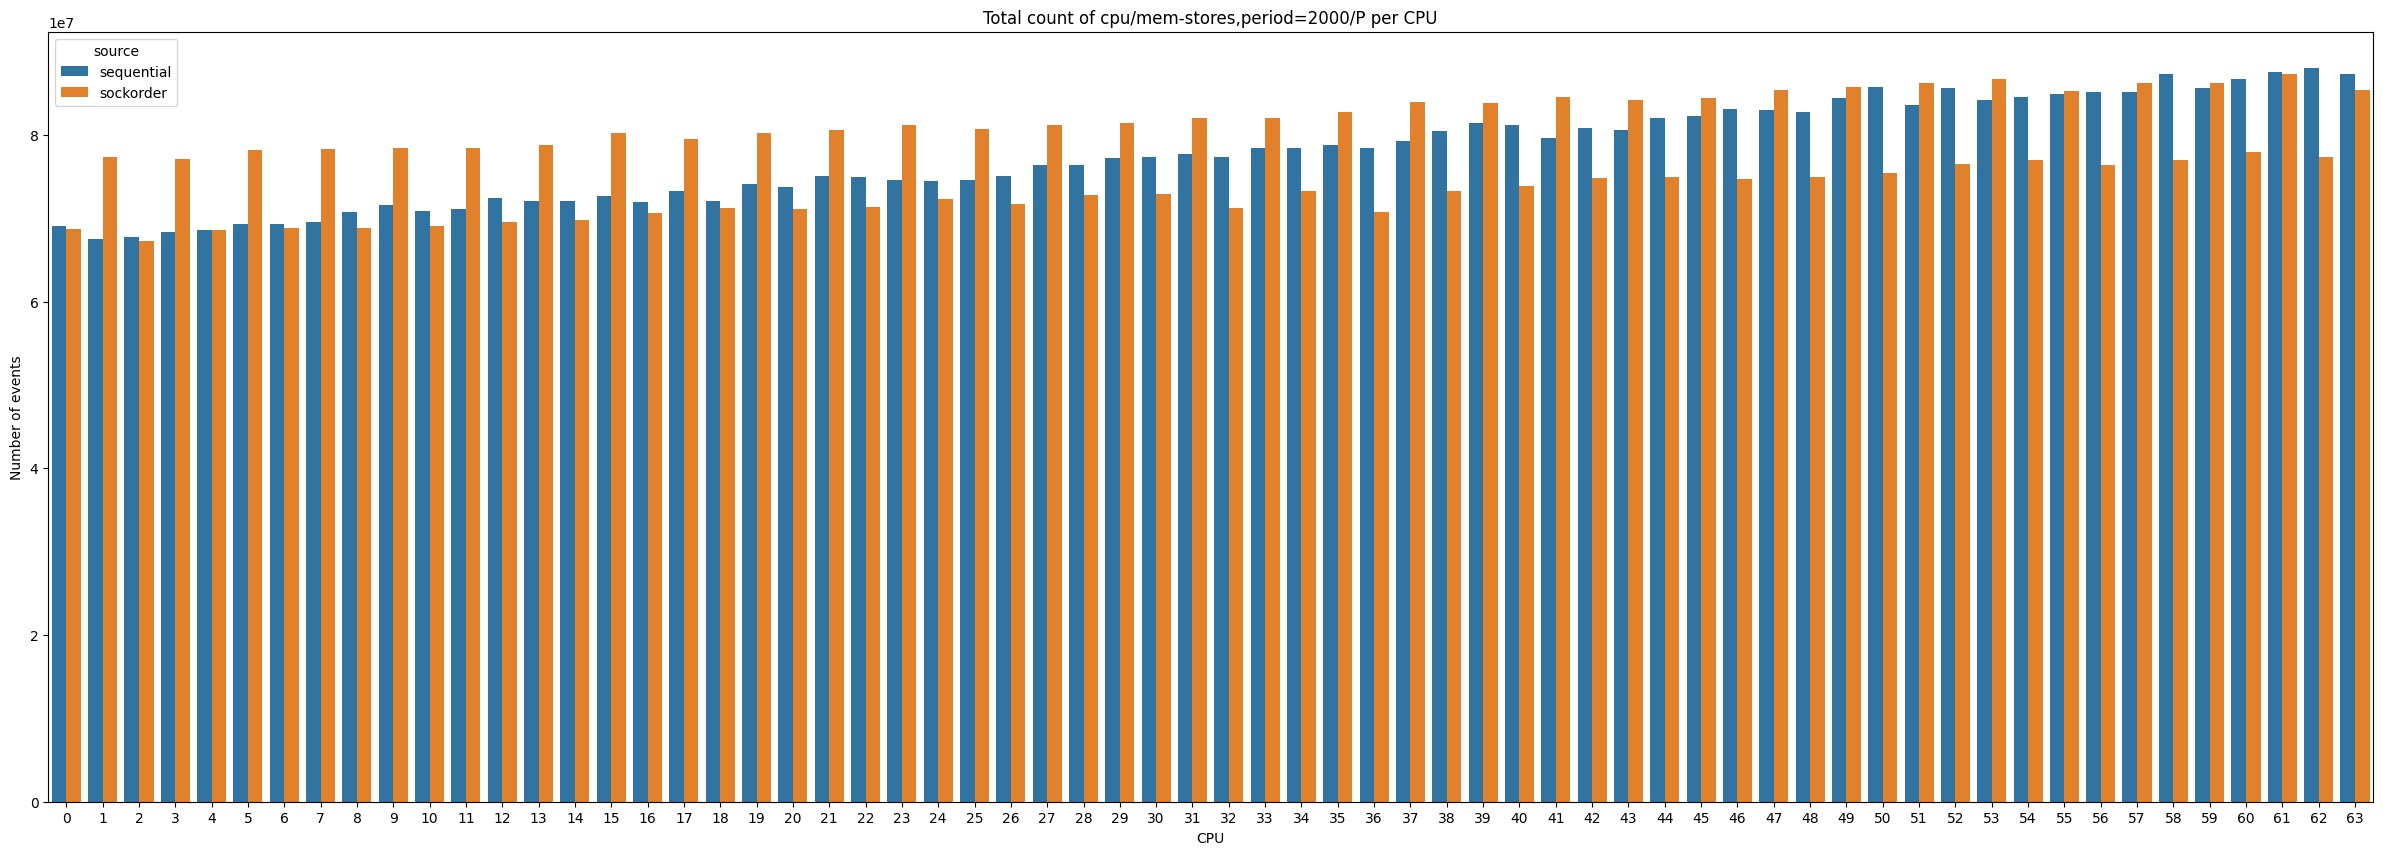

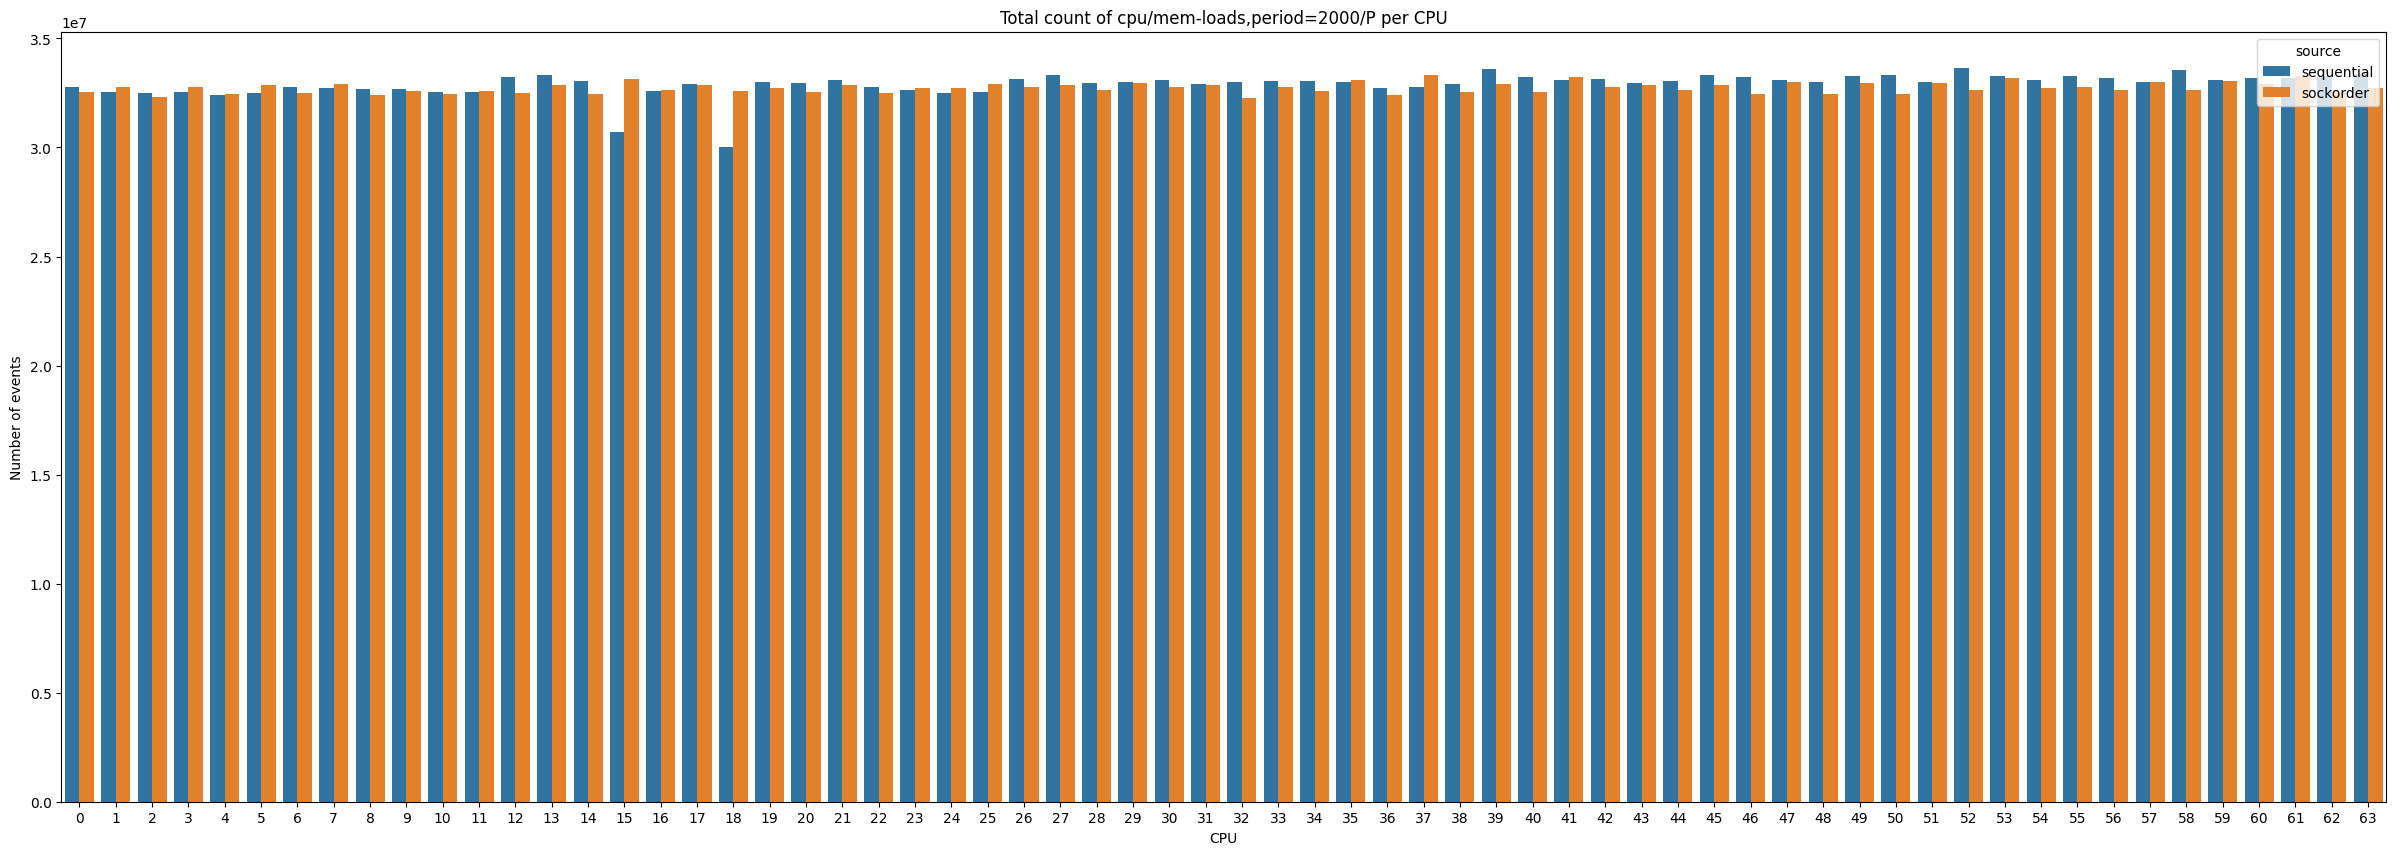

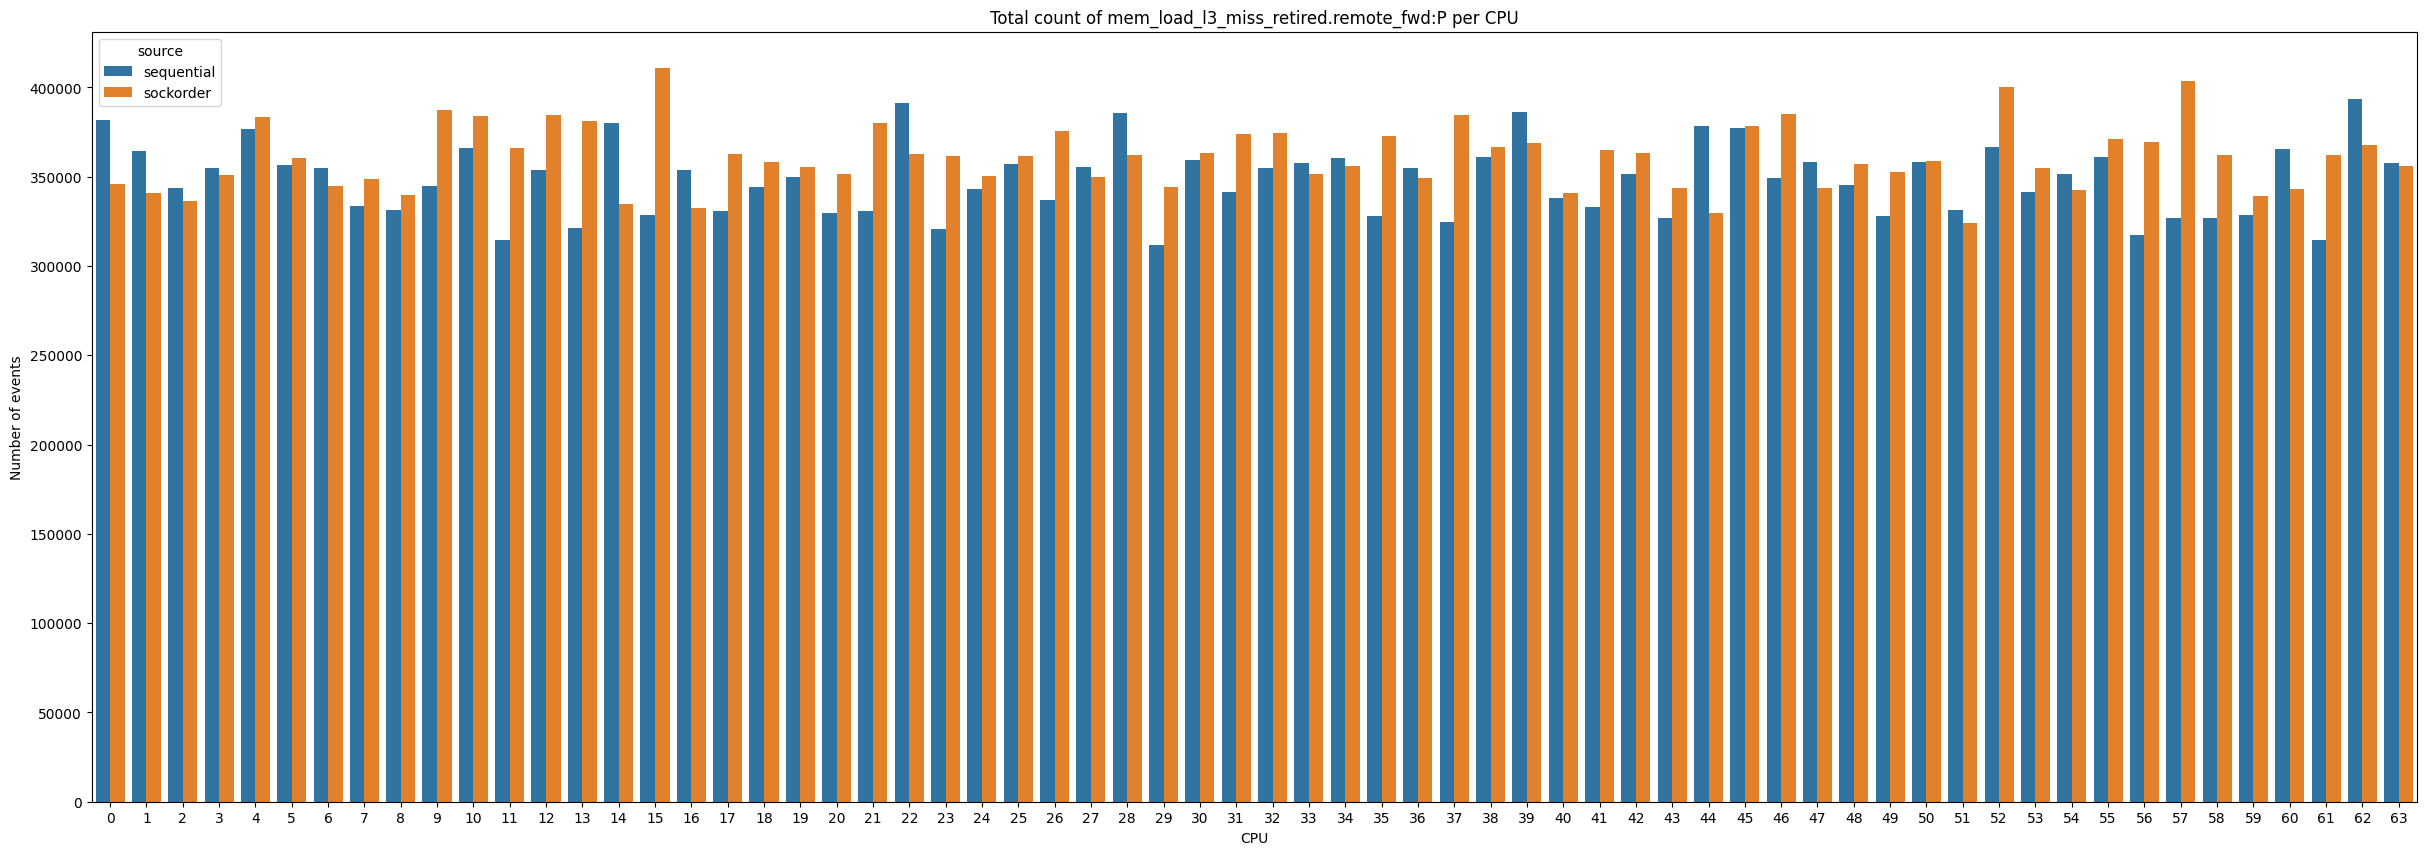

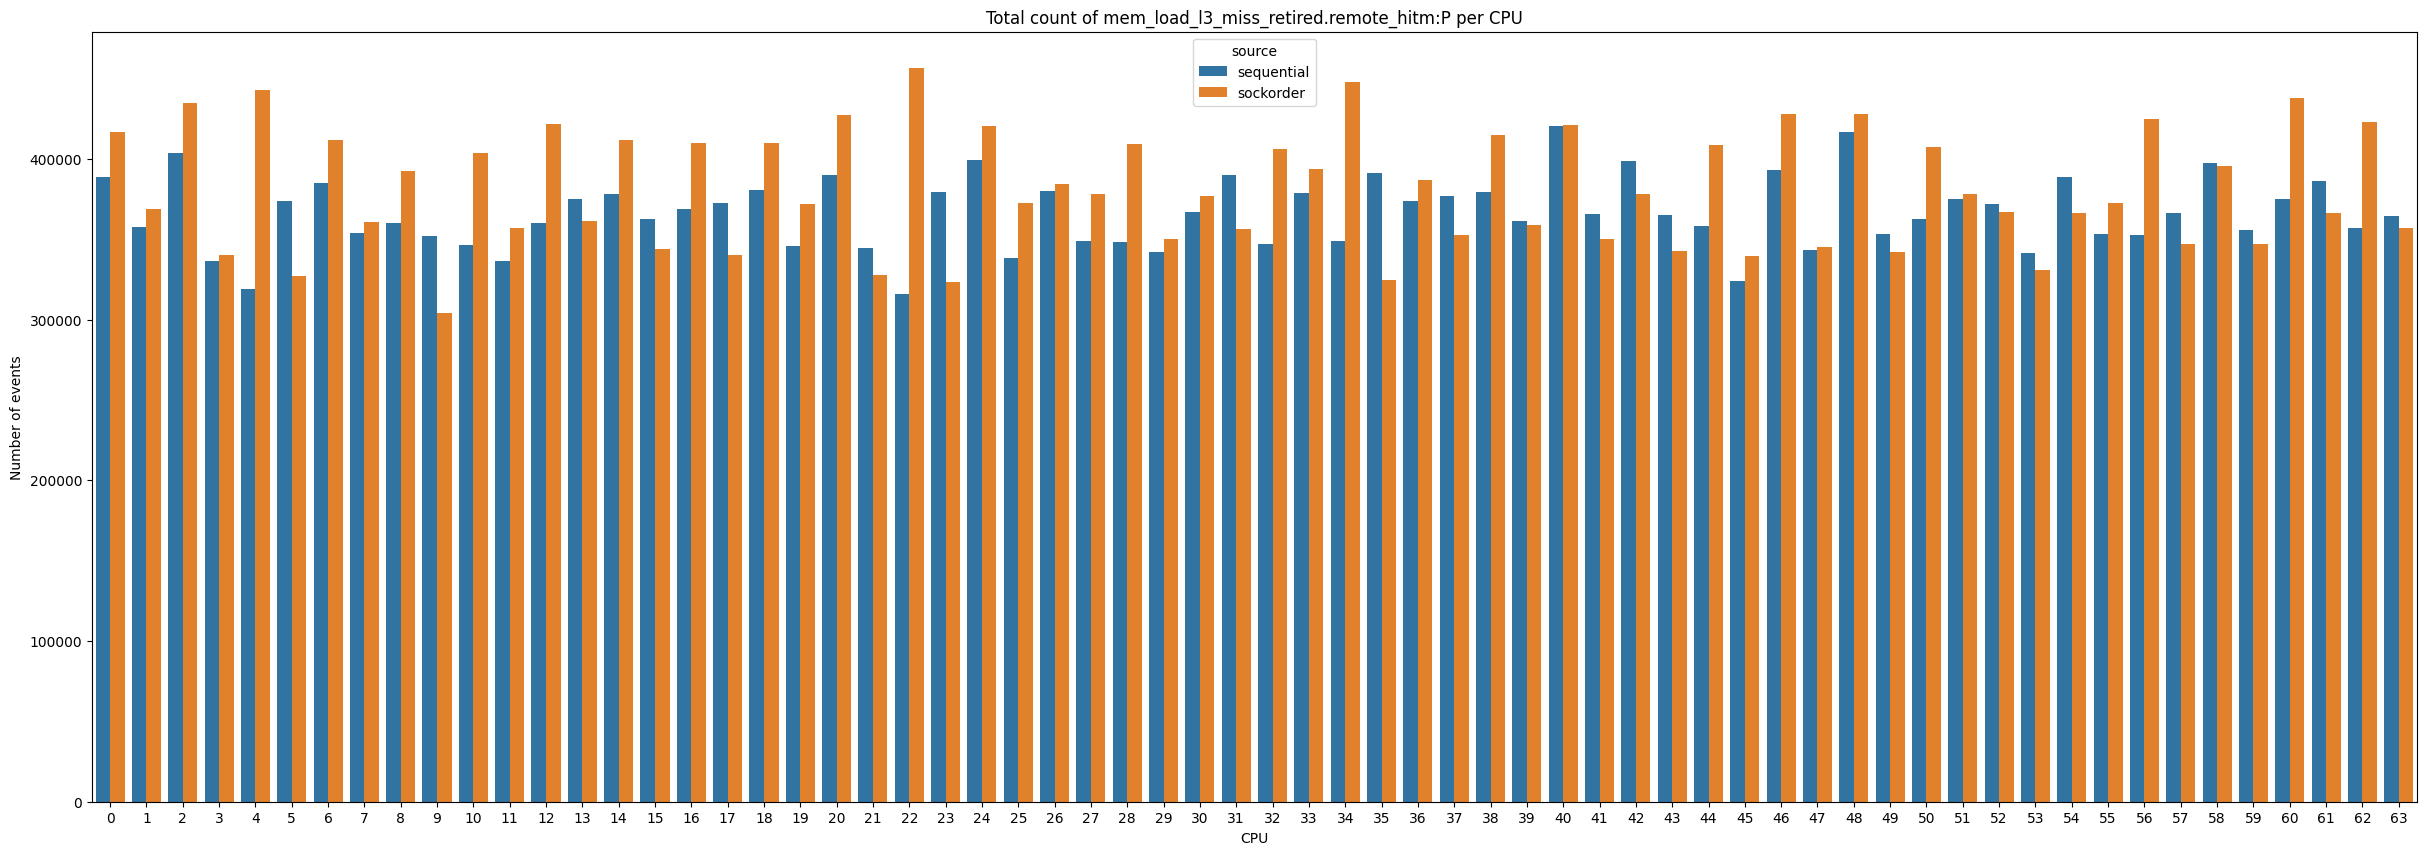

In [98]:
for event in seq_df['event'].unique() :
    plot_event_count_per_cpu([seq_df, sock_df], ["sequential", "sockorder"], event)
    # plot_event_count_per_cpu([seq_df], ["sequential"], event)

## Address space

### Vizualization

In [68]:
def relative_to_bounds(bounds: Tuple[int, int], relative_range = 1000):
    min_range = events_df['phys'].min()
    max_range = events_df['phys'].max()
    range = max_range - min_range
    return int((bounds[0] / relative_range) * range), int((bounds[1] / relative_range) * range)

def bounds_to_relative(df: pd.DataFrame, bounds: Tuple[int, int], variable: str, relative_range = 100):
    min_range = df[variable].min()
    max_range = df[variable].max()
    range = max_range - min_range
    return ((bounds[0] - min_range) * relative_range) / range, ((bounds[1] - min_range) * relative_range) / range

## Visualization of memory

TODO : Do the same thing but over time

In [91]:
def plot_physical_memory_map(df: pd.DataFrame, outer_clusters_size = 1e10, inner_clusters_size = 1e8):
    outer_groups = get_groups(df['phys'].to_numpy(), outer_clusters_size, 1000)
    print_groups(outer_groups)
        
    fig, axs = plt.subplots(1, len(outer_groups), figsize=(40, 40))

    for i, og in enumerate(outer_groups):
        inner_df = extract_group(df, og, variable="phys").sort_values("phys").reset_index(drop=True)
        sorted_local_physaddr = inner_df["phys"].to_numpy()
        inner_groups = get_groups(sorted_local_physaddr, inner_clusters_size, 1000)
        # print_groups(inner_groups)
        
        axs[i].plot(range(len(sorted_local_physaddr)), sorted_local_physaddr)
        for cluster in inner_groups :
            axs[i].axhline(y=cluster[0], color='g', linestyle='--', linewidth=0.2)
            axs[i].axhline(y=cluster[1], color='purple', linestyle='--', linewidth=0.2)
            
        for nub in NODE_UPPER_BOUNDARIES:
            if nub >= og[0] and nub < og[1]:
                axs[i].axhline(y=nub, color='r', linestyle='--', linewidth=0.8)
            
        relative_bounds = bounds_to_relative(df, og, 'phys')
        axs[i].set_title(f"{'{:.2f}'.format(relative_bounds[0])} - {'{:.2f}'.format(relative_bounds[1])} % of entire address space")
        
        l3_miss_dram_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_dram:P"]
        l3_miss_fwd_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_fwd:P"]
        l3_miss_hitm_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_hitm:P"]
        
        if len(l3_miss_dram_df) > 0:
            axs[i].scatter(l3_miss_dram_df.index, l3_miss_dram_df['phys'], label="l3 miss remote dram", color='r', s=15, alpha=0.5, zorder=3)
        if len(l3_miss_fwd_df) > 0:
            axs[i].scatter(l3_miss_fwd_df.index, l3_miss_fwd_df['phys'], label="l3 miss remote fwd", color='tab:orange', s=10, alpha=0.5, zorder=4)
        if len(l3_miss_hitm_df) > 0:
            axs[i].scatter(l3_miss_hitm_df.index, l3_miss_hitm_df['phys'], label="l3 miss remote hitm", color='tab:pink', s=10, alpha=0.5, zorder=5)
        
        # for event in inner_df['event'].unique() :
        #     if "l3_miss_retired.remote_dram" not in event:
        #         continue
        #     # plot_event_count_per_cpu(events_df_sorted_phys, event)
        #     filtered_df = events_df_sorted_phys.loc[events_df_sorted_phys['event'] == event]
        #     plt.scatter(filtered_df.index, filtered_df['phys'], label=event, c='r', s=2, alpha=0.8, zorder=10)

        # # plt.scatter(l3_remote_df.index, l3_remote_df['phys'], s=2, color='r', alpha=0.1)

        # plt.axhline(y=NODE_1_PHYS_ADDR_START, color='r', linestyle='--', linewidth=0.8)
        # plt.gcf().set_size_inches(10, 15)
        # plt.title("Physical addresses ordered")
        # plt.legend(title='Cache Result', loc="best")
    plt.show()

Group 0 -- bounds : (4295331976, 8887730152), width : 4.592e+09, size : 2295389
Group 1 -- bounds : (33298583088, 33330343216), width : 3.176e+07, size : 1171
Group 2 -- bounds : (102552395824, 107116229536), width : 4.564e+09, size : 2353456
Group 3 -- bounds : (207132196920, 207232166056), width : 9.997e+07, size : 19313


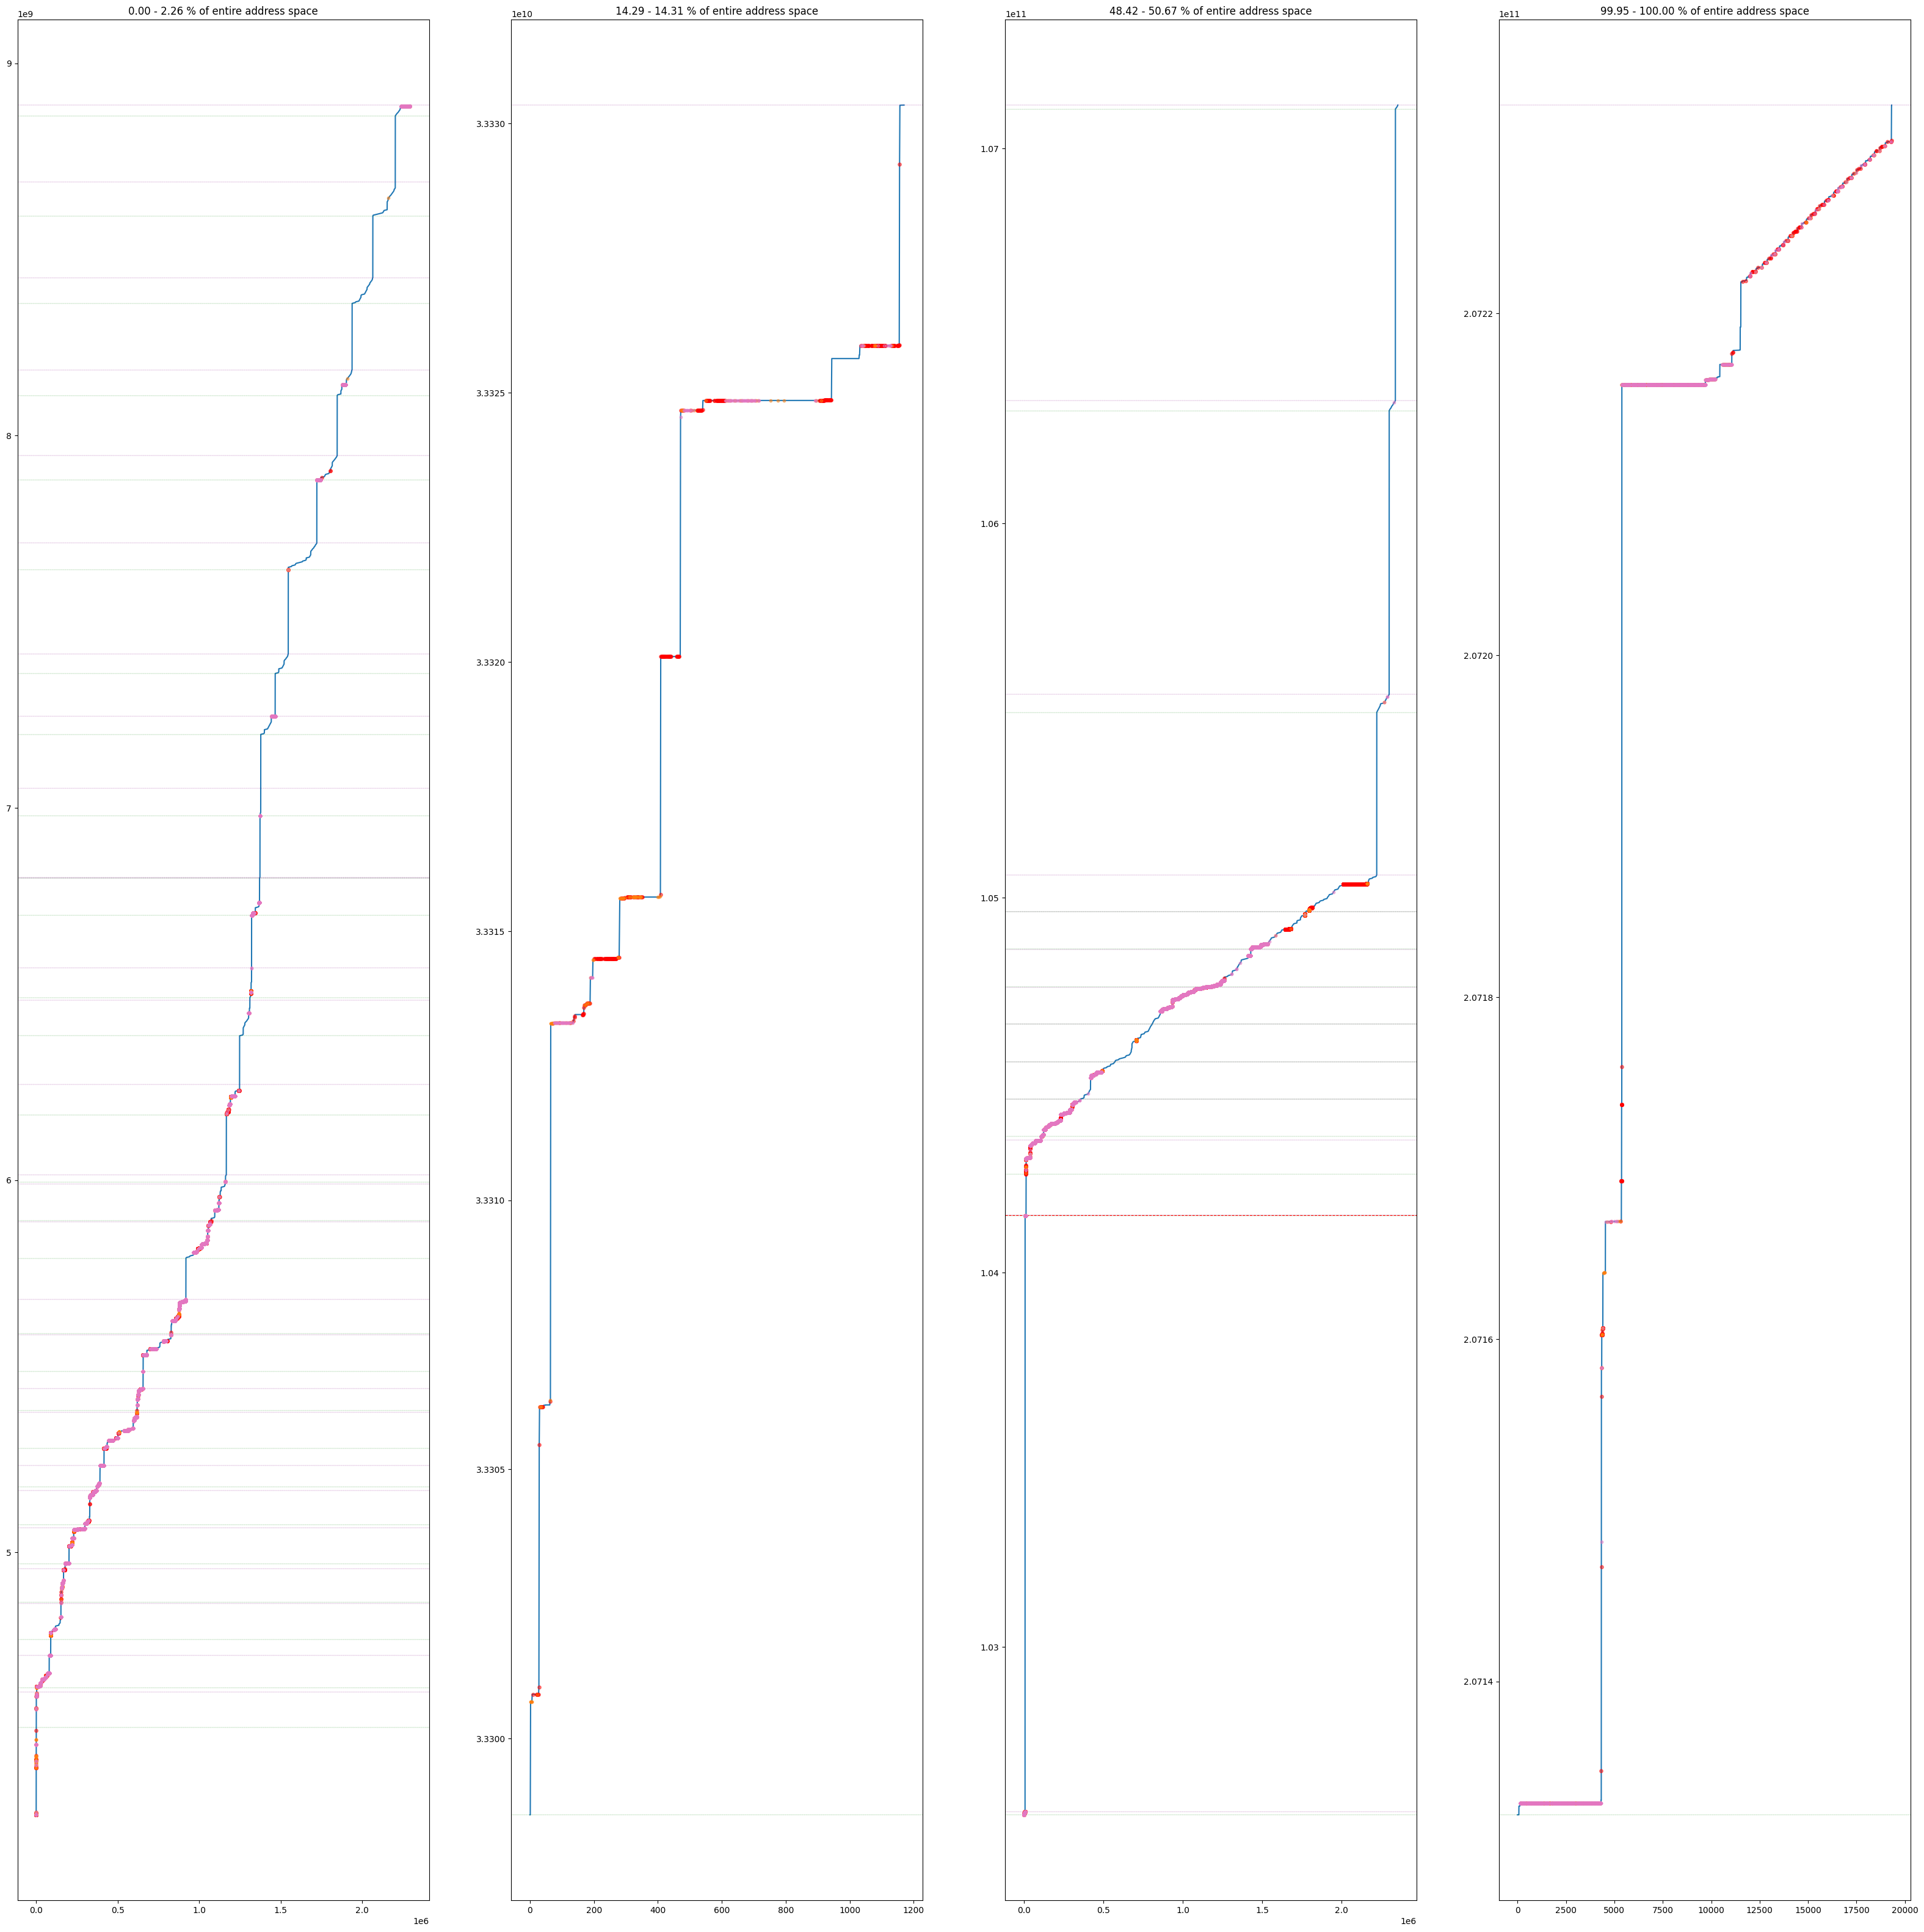

In [92]:
plot_physical_memory_map(sock_df)

In [153]:
test_df = seq_data.alloc_df
test_df['end_addr'] = (test_df['pfn'] + (2 ** test_df['order'])) * PAGE_SIZE
test_df['end_addr']

0        104311816192
1        104324825088
2        207162654720
3        104409272320
4        115887288320
             ...     
12595      8735862784
12596      7286976512
12597      4618059776
12598      8545239040
12599      4611624960
Name: end_addr, Length: 12600, dtype: int64

In [154]:
def addr_pfn(phys_addr: int):
    return int(phys_addr & ~(PAGE_SIZE - 1)) // PAGE_SIZE

def plot_phys_mem_with_alloc(config_data: ConfigData, cpuid = [], exclude_cpuid = [], 
             min_addr: Optional[int] = None, max_addr: Optional[int] = None, 
             min_t: Optional[int] = None, max_t: Optional[int] = None, 
             w = 60, h = 30, dot_size = 10):
    
    addr_type = "phys"
    alloc_df = config_data.alloc_df
    df = config_data.access_df
    cpu_df = df.loc[df['cpuid'].isin(cpuid)] if cpuid else df
    cpu_df = df.loc[~df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else cpu_df
    bounded_df = cpu_df
    
    if min_addr is not None or max_addr is not None:
        bounded_df = filter_in_bounds(bounded_df, (min_addr, max_addr), addr_type)
        alloc_df = filter_in_bounds(alloc_df, (None, addr_pfn(max_addr) + 1), 'pfn')
        alloc_df['end_addr'] = (alloc_df['pfn'] + (2 ** alloc_df['order'])) * PAGE_SIZE
        alloc_df = alloc_df.loc[alloc_df['end_addr'] >= min_addr]
        # alloc_df = filter_in_bounds(alloc_df, (addr_pfn(min_addr), addr_pfn(max_addr)), 'pfn')
        
    if min_t is not None or max_t is not None :
        bounded_df = filter_in_bounds(bounded_df, (min_t, max_t), 'time')
        alloc_df = filter_in_bounds(alloc_df, (min_t, max_t), 'time')
        
    me_names = get_memory_event_names(bounded_df)
    # alloc_df = bounded_df.loc[bounded_df['event'].str.contains("alloc")]
    loads_df = bounded_df.loc[bounded_df['event'] == me_names.loads]
    stores_df = bounded_df.loc[bounded_df['event'] == me_names.stores]
    l3_miss_dram_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_dram]
    l3_miss_fwd_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_fwd]
    l3_miss_hitm_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_hitm]
    
    cpu_cmap = plt.get_cmap('tab10')
    
    print(f"Plotting {len(alloc_df)} allocations")
    display(alloc_df)
    if len(alloc_df) > 0:
        for i, alloc_row in alloc_df.iterrows():
        # for time, pfn in zip(alloc_df['time'], alloc_df['pfn']):
            start_phys_addr = alloc_row['pfn'] * PAGE_SIZE
            end_phys_addr = (alloc_row['pfn'] + (1 << alloc_row['order'])) * PAGE_SIZE
            # print(f"start_phys_addr : {start_phys_addr}, end_phys_addr : {end_phys_addr}")
            color = cpu_cmap(alloc_row['cpuid'] % cpu_cmap.N)
            plt.vlines(alloc_row['time'], ymin=start_phys_addr, ymax=end_phys_addr, linewidth=2, colors=color)
            plt.scatter([alloc_row['time'], alloc_row['time']], [start_phys_addr, end_phys_addr], marker='_', color=color)
    
    if len(loads_df) > 0:
        plt.scatter(loads_df['time'], loads_df[addr_type], label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    if len(stores_df) > 0:
        plt.scatter(stores_df['time'], stores_df[addr_type], label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df[addr_type], label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df[addr_type], label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df[addr_type], label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    cpuids = bounded_df['cpuid'].unique()
    for cid in cpuids :
        curr_df = bounded_df.loc[bounded_df['cpuid'] == cid]
        plt.plot(curr_df['time'], curr_df[addr_type], label=f"CPU {cid}", linestyle='--', linewidth=0.6, color=cpu_cmap(cid % cpu_cmap.N), alpha=0.5)
        
    plt.gcf().set_size_inches(w, h)
    plt.minorticks_on()
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel(addr_type)
    plt.title(f"Scatter plot of {addr_type} addresses over time")
    plt.legend(title='Cache Result', loc='upper right')
    plt.show()

In [123]:
cmap = plt.get_cmap('tab10')
cmap.N

10

In [56]:
def plotmem(df: pd.DataFrame, column: str = 'phys', cpuid = [], exclude_cpuid = [], min_t = None, max_t = None, w = 60, h = 30, dot_size = 10) :
    cpu_df = df.loc[df['cpuid'].isin(cpuid)] if cpuid else df
    cpu_df = df.loc[~df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else cpu_df
    bounded_df = cpu_df
    
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        bounded_df = filter_in_bounds(bounded_df, (min_t, max_t), 'time')
        
    me_names = get_memory_event_names(bounded_df)
    alloc_df = bounded_df.loc[bounded_df['event'].str.contains("alloc")]
    loads_df = bounded_df.loc[bounded_df['event'] == me_names.loads]
    stores_df = bounded_df.loc[bounded_df['event'] == me_names.stores]
    l3_miss_dram_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_dram]
    l3_miss_fwd_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_fwd]
    l3_miss_hitm_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_hitm]
    
    print(f"Plotting {len(alloc_df)} allocations")
    if column == 'phys' and len(alloc_df) > 0:
        for time, start_phys_addr in zip(alloc_df['time'], alloc_df['phys']):
            end_phys_addr = start_phys_addr + PAGE_SIZE
            plt.vlines(time, ymin=start_phys_addr, ymax=end_phys_addr, linewidth=100)
            plt.plot([time, time], [start_phys_addr, end_phys_addr], '-')
    
    if len(loads_df) > 0:
        plt.scatter(loads_df['time'], loads_df[column], label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    if len(stores_df) > 0:
        plt.scatter(stores_df['time'], stores_df[column], label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df[column], label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df[column], label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df[column], label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    # TODO Plot the other types of L3 miss with different color like orange and purple
    # plt.scatter(l3_miss_remote_df['time'], l3_miss_remote_df['phys'], label="l3 miss remote dram", color='r', s=3, alpha=0.5, zorder=10)
    
    cpuids = bounded_df['cpuid'].unique()
    for cid in cpuids :
        curr_df = bounded_df.loc[bounded_df['cpuid'] == cid]
        plt.plot(curr_df['time'], curr_df[column], label=f"CPU {cid}", linestyle='--', linewidth=0.4, alpha=0.5)
        
    plt.gcf().set_size_inches(w, h)
    plt.minorticks_on()
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.title(f"Scatter plot of {column} addresses over time")
    plt.legend(title='Cache Result', loc='upper right')
    plt.show()

## Fixed page investigation

In here we want to get the pfn for an address, and then filter all the access to that particular pfn.
x axis : time
y axis : cpu

In [42]:
test_df = filter_in_bounds(seq_data.access_df, (TIME_START, TIME_END), "time")
test_df

cpuid      time  period                       event            virt  \
2415772     15  0.678961     800  cpu/mem-loads,period=800/P  94538618356996   

             cache_result  latency        phys  cpu_node  memory_node  
2415772  LVL L1 or L1 hit        7  9174222084         1            0

In [53]:
# Type should be either phys or virt
def plot_page_accesses(df: pd.DataFrame, address: int, addr_type: str, radius = 0, min_t = None, max_t = None, w = 24, dot_size = 15):
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        df = filter_in_bounds(df, (min_t, max_t), 'time')
        
    mask = ~(PAGE_SIZE - 1)
    pfn = address & mask
    lower_bound = pfn - radius * PAGE_SIZE
    upper_bound = pfn + (radius + 1) * PAGE_SIZE - 1
    
    print(f"Address type : {addr_type}, lower bound : {lower_bound}, upper bound : {upper_bound}, size : {upper_bound - lower_bound + 1}")
    
    pages_df = filter_in_bounds(df, (lower_bound, upper_bound), addr_type)
    cpuids = list(pages_df.cpuid.unique())
    me_names = get_memory_event_names(pages_df)
    loads_df = pages_df.loc[pages_df['event'] == me_names.loads]
    stores_df = pages_df.loc[pages_df['event'] == me_names.stores]
    l3_miss_dram_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_dram]
    l3_miss_fwd_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_fwd]
    l3_miss_hitm_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_hitm]
    
    if len(loads_df) > 0:
        plt.scatter(loads_df['time'], loads_df.cpuid, label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    if len(stores_df) > 0:
        plt.scatter(stores_df['time'], stores_df.cpuid, label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df.cpuid, label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df.cpuid, label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df.cpuid, label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    plt.gcf().set_size_inches(w, len(cpuids))
    plt.ylim(bottom = min(cpuids) - 1, top = max(cpuids) + 1)
    plt.grid(which="major", axis="y")
    plt.yticks(list(range(min(cpuids), max(cpuids) + 2)))
    plt.show()
    
    return lower_bound, upper_bound, cpuids

Address type : virt, lower bound : 140429496745984, upper bound : 140429503303679, size : 6557696


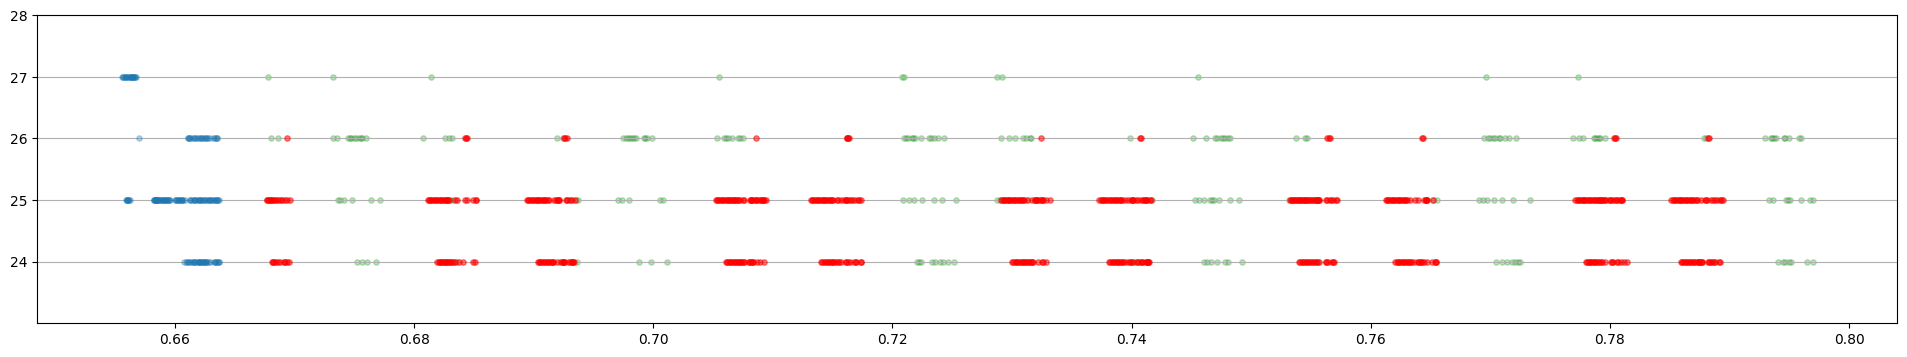

(140429496745984, 140429503303679, [27, 25, 26, 24])

In [54]:
plot_page_accesses(seq_data.access_df, 140429500025728, "virt", radius=800, max_t=0.8)

Plotting 0 allocations


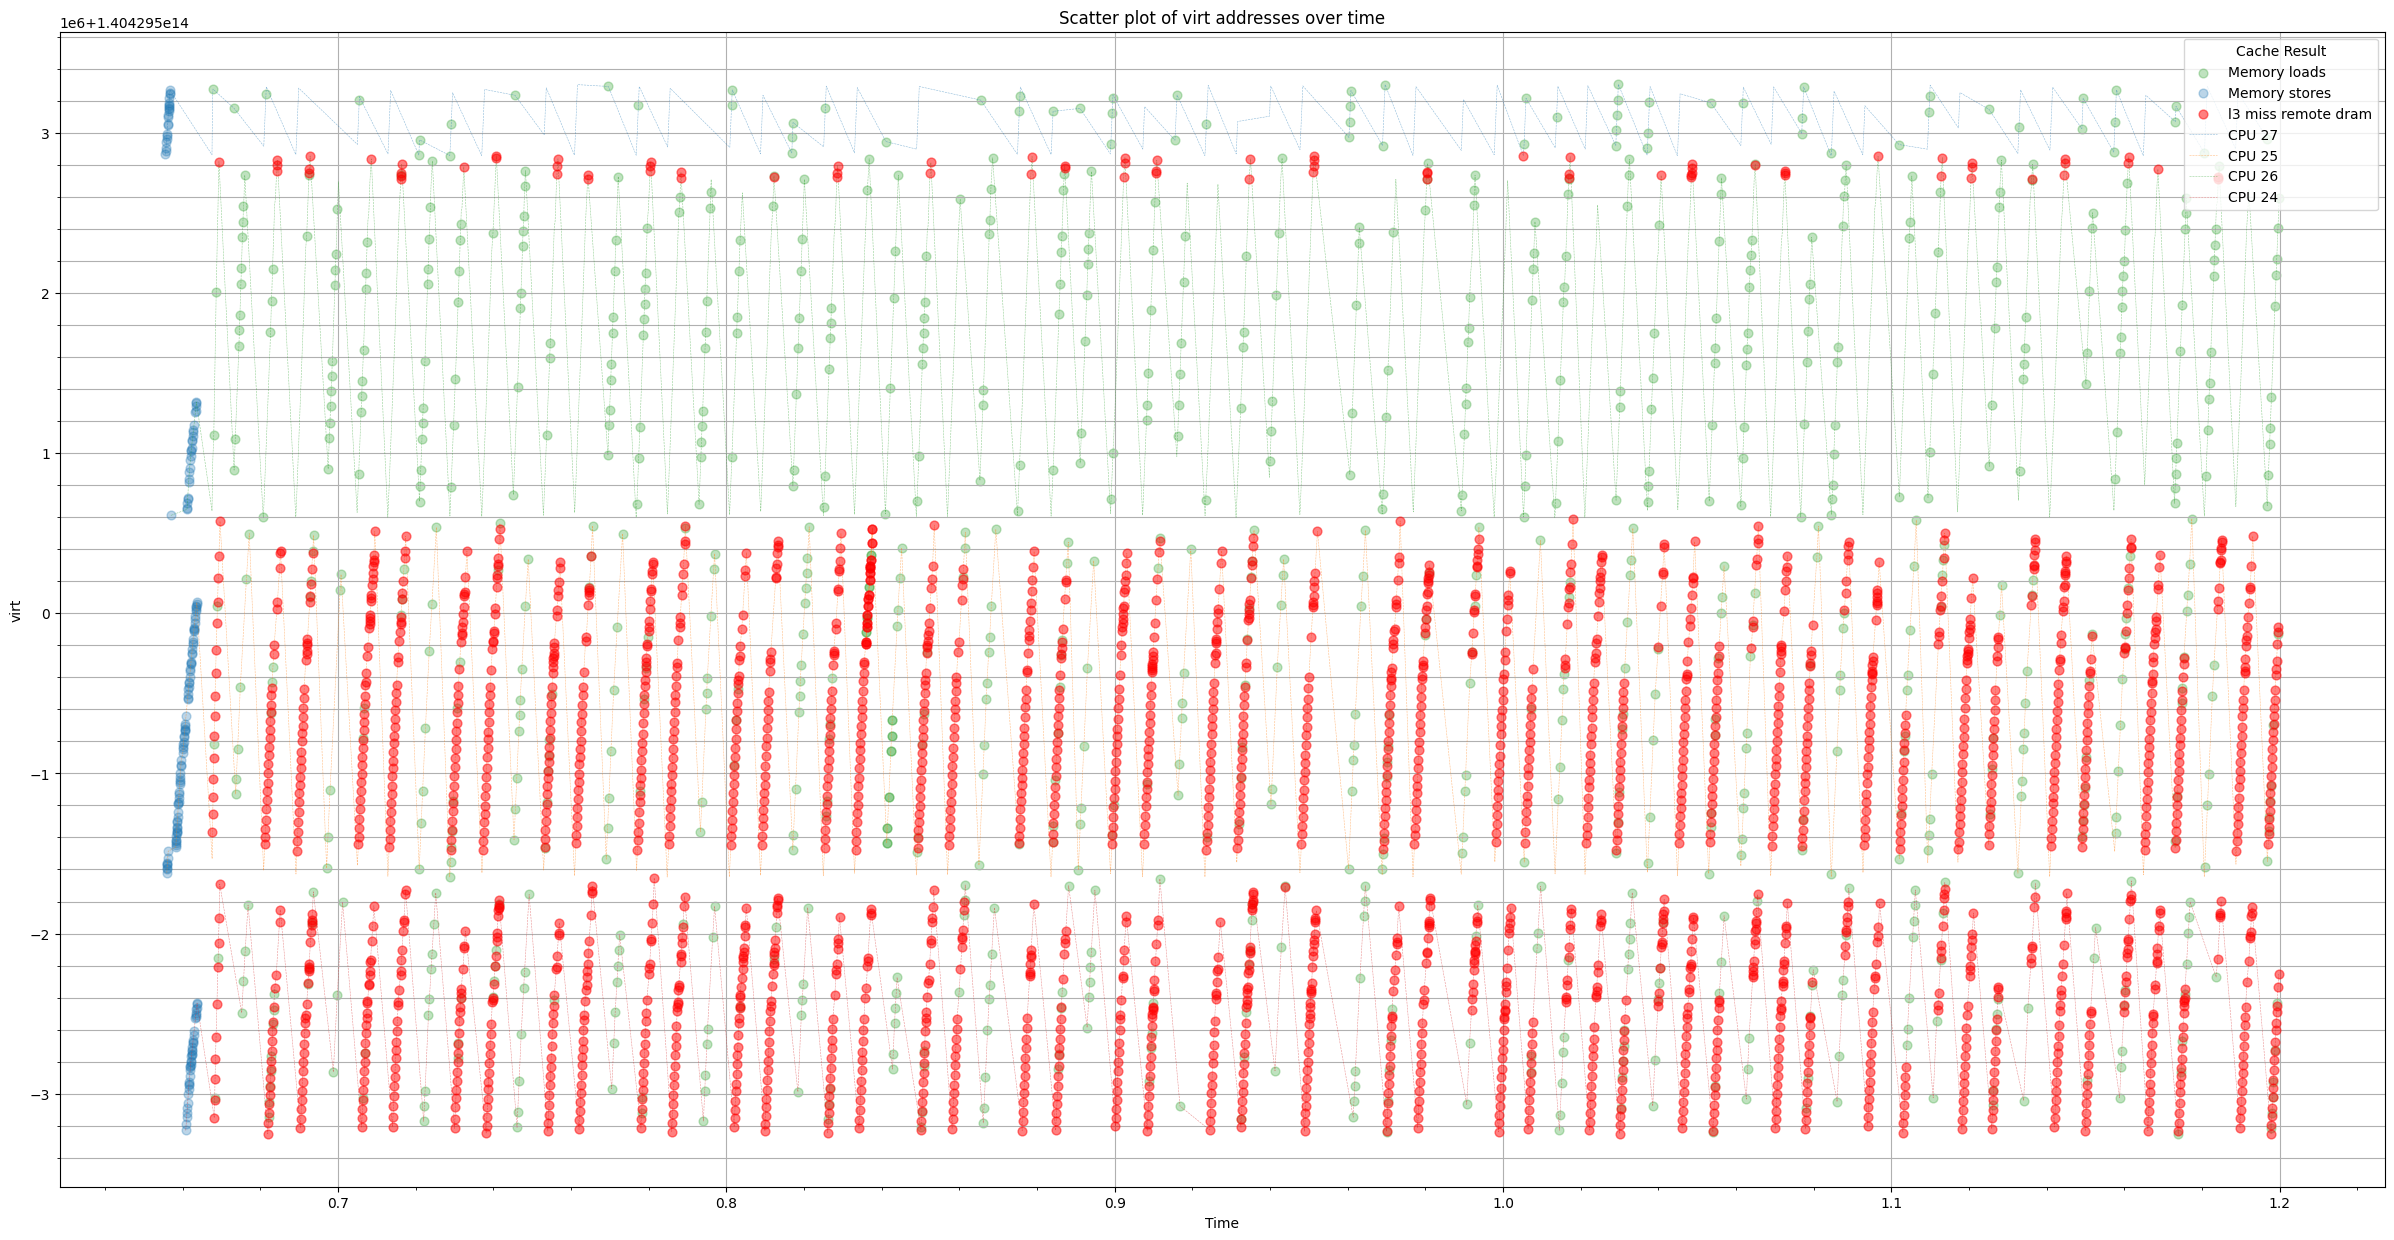

In [58]:
plotmem(filter_in_bounds(seq_data.access_df, (140429496745984, 140429503303679), "virt"), column="virt", min_t=0.0, max_t=1.2, w = 30, h = 15, dot_size=40)

In [ ]:
plot_page_accesses(seq_data.access_df, 140429500025728, "virt", radius=800, max_t=0.8)

Curr addr : 0x4d9970b80, pfn : 0x4d9970, node : 0
Address type : phys, lower bound : 20826324992, upper bound : 20834521087, size : 8196096


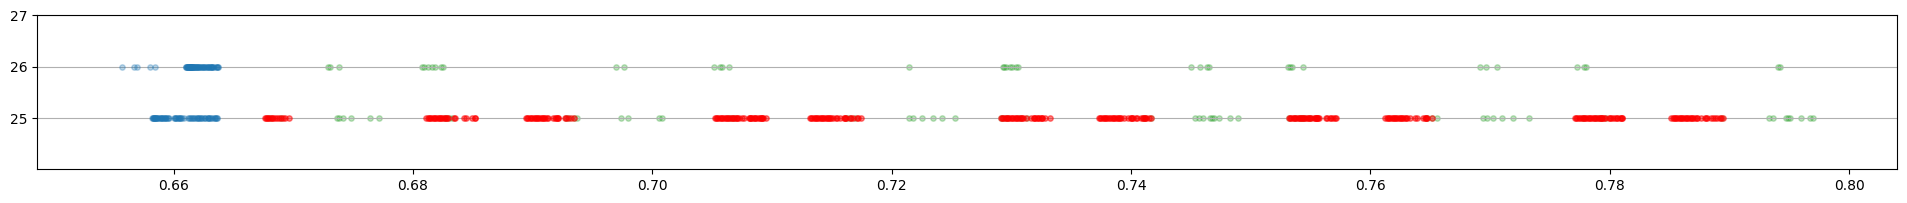

(20826324992, 20834521087, [26, 25])

In [116]:
curr_phys = 20830423936
print(f"Curr addr : {hex(curr_phys)}, pfn : {hex(addr_pfn(curr_phys))}, node : {get_node_for_physical_address(curr_phys)}")
get_node_for_physical_address(curr_phys)
plot_page_accesses(seq_data.access_df, curr_phys, "phys", 1000, max_t=0.8)

In [108]:
hex(addr_pfn(curr_phys))

'0x4d9970'

In [115]:
# tmp_df = seq_data.alloc_df
# hex_pfn = [hex(pfn) for pfn in sorted(tmp_df['pfn'])]
# hex_pfn

In [132]:
seq_data.alloc_df.sort_values('pfn')

cpuid      time                           event       pfn  order  \
2851     56  0.163094  kmem:mm_page_alloc_zone_locked   1079465      0   
3047     42  0.164853  kmem:mm_page_alloc_zone_locked   1080882      0   
7916     34  0.652953  kmem:mm_page_alloc_zone_locked   1082460      0   
7917     34  0.652953  kmem:mm_page_alloc_zone_locked   1082461      0   
7896     34  0.652930  kmem:mm_page_alloc_zone_locked   1084240      0   
...     ...       ...                             ...       ...    ...   
7579     25  0.652710  kmem:mm_page_alloc_zone_locked  50580277      0   
9719     55  0.654559              kmem:mm_page_alloc  50580292      0   
6152     63  0.174065  kmem:mm_page_alloc_zone_locked  50589979      0   
6788     63  0.174534  kmem:mm_page_alloc_zone_locked  50590382      0   
6789     63  0.174535  kmem:mm_page_alloc_zone_locked  50590383      0   

      cpu_node  memory_node  
2851         0            0  
3047         0            0  
7916         0            0  
7917         0            0  
7896         0            0  
...        ...          ...  
7579         1            1  
9719         1            1  
6152         1            1  
6788         1            1  
6789         1            1  

[12600 rows x 7 columns]

Plotting 4 allocations


cpuid      time                           event      pfn  order  \
9955      26  0.654881  kmem:mm_page_alloc_zone_locked  5085184      9   
9956      26  0.654882  kmem:mm_page_alloc_zone_locked  5085696      9   
10014     26  0.655933              kmem:mm_page_alloc  5085184      9   
10107     26  0.657974              kmem:mm_page_alloc  5085696      9   

       cpu_node  memory_node  
9955          0            0  
9956          0            0  
10014         0            0  
10107         0            0

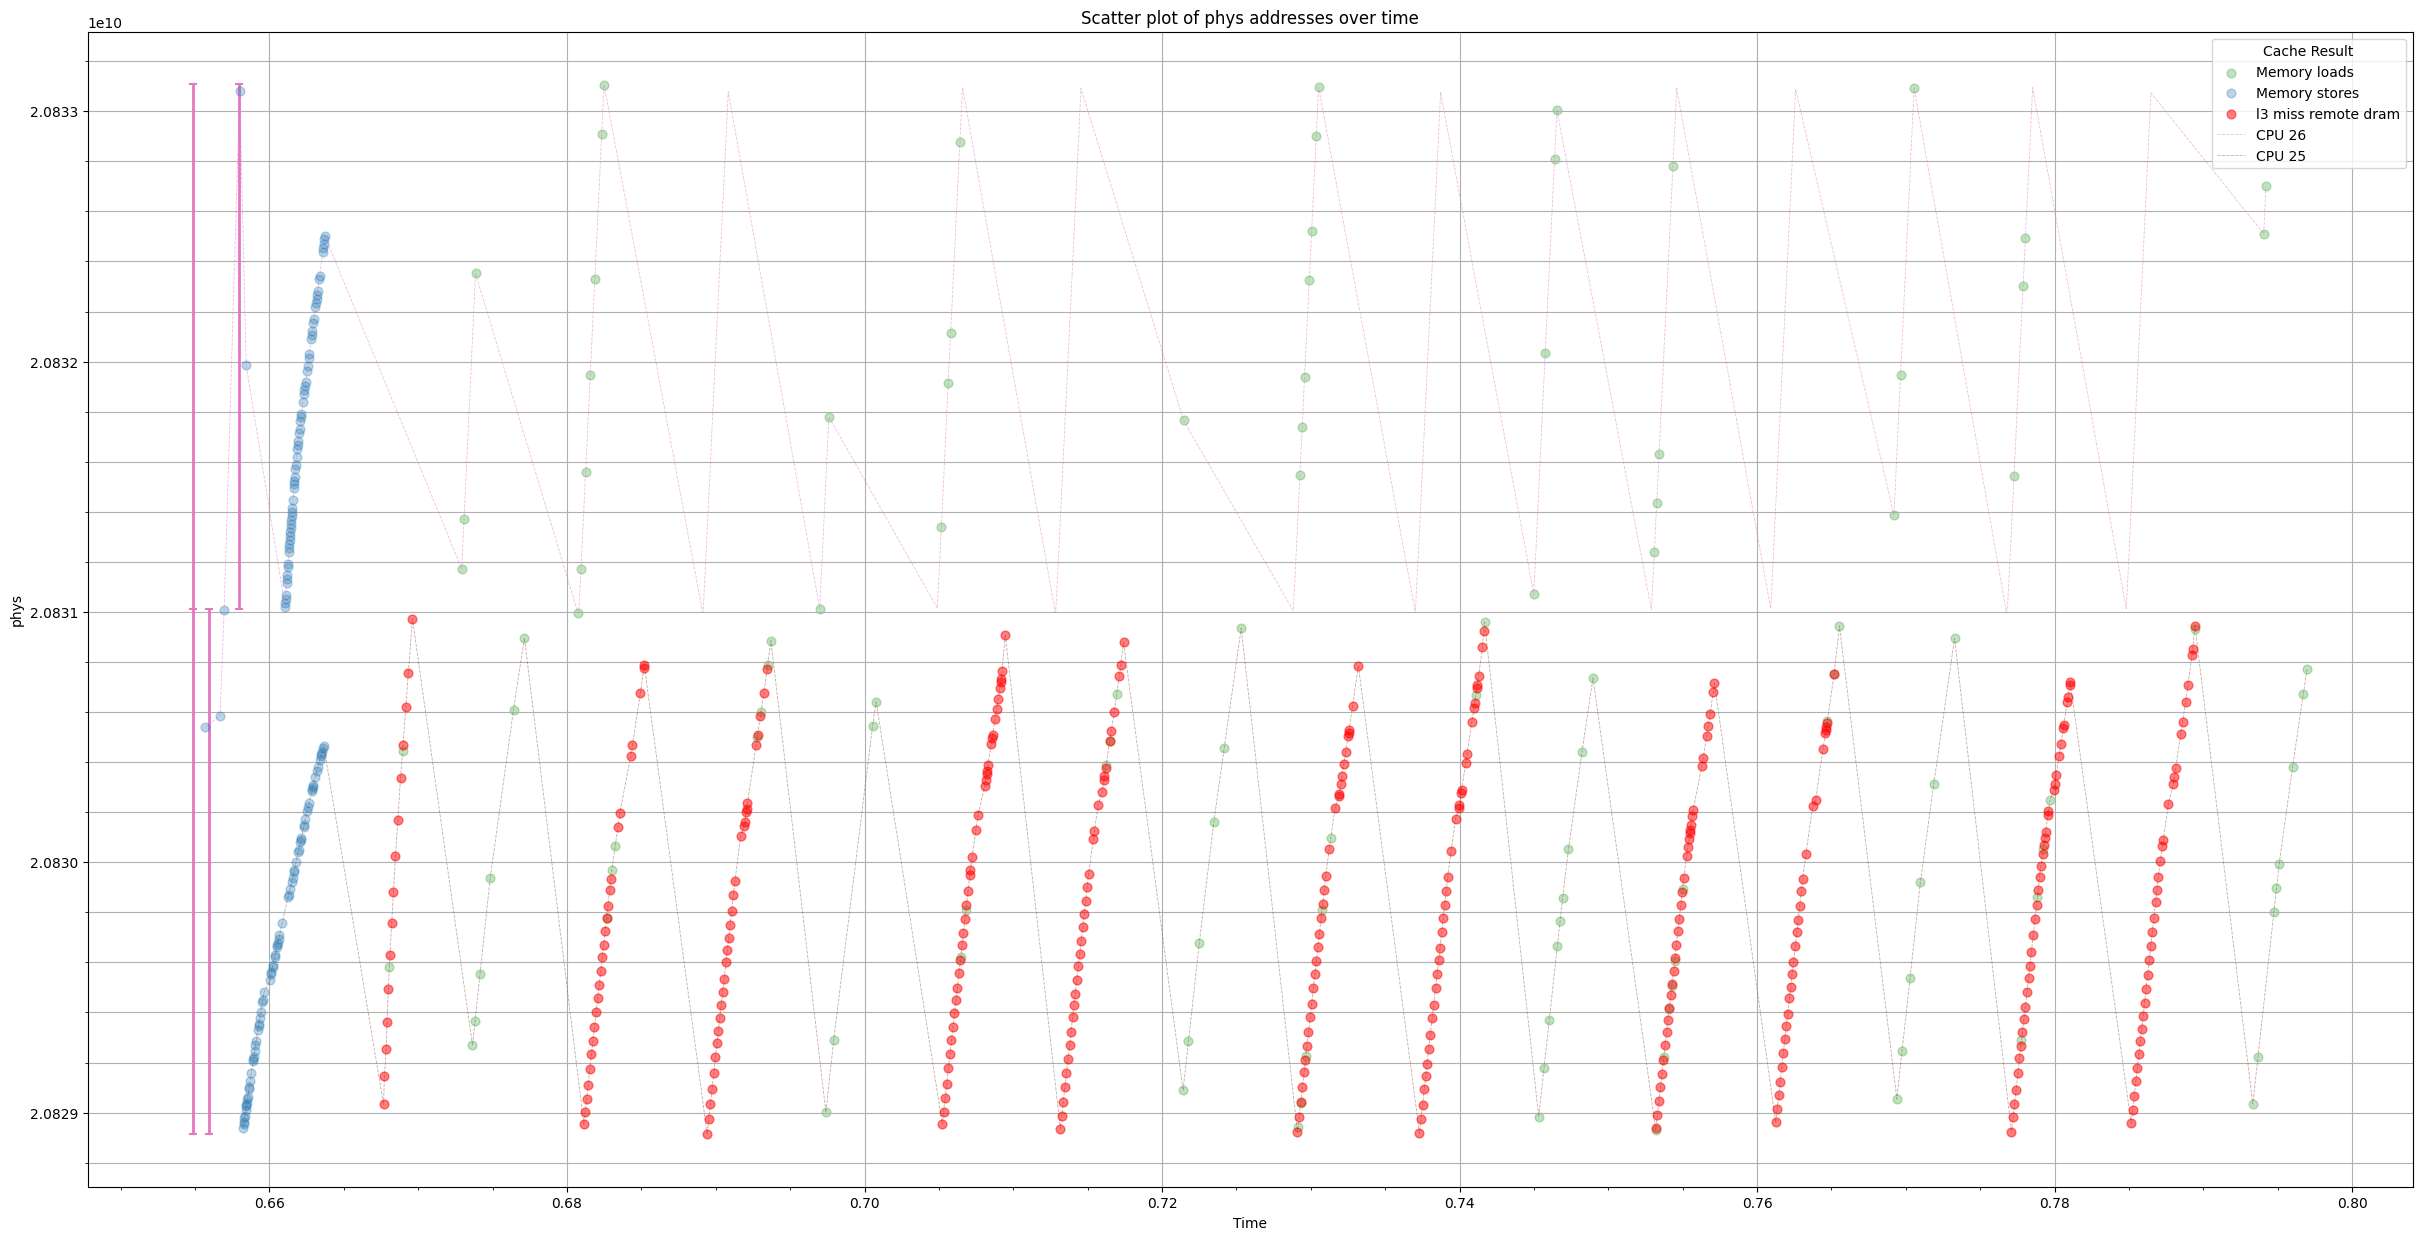

In [143]:
plot_phys_mem_with_alloc(seq_data, min_addr=20826324992, max_addr=20834521087, max_t=0.8, w=30, h=15, dot_size=40)

In [147]:
def multiplot_phys(config_data: ConfigData, phys_addr: int, radius = 0, min_t = None, max_t = None, w=30, h=15, dot_size=40):
    min_addr, max_addr, cpuids = plot_page_accesses(config_data.access_df, phys_addr, "phys", radius, min_t=min_t, max_t=max_t, w=w, dot_size=dot_size)
    plot_phys_mem_with_alloc(config_data, min_addr=min_addr, max_addr=max_addr, max_t=max_t, w=w, h=h, dot_size=dot_size)

Address type : phys, lower bound : 20825096192, upper bound : 20835749887, size : 10653696


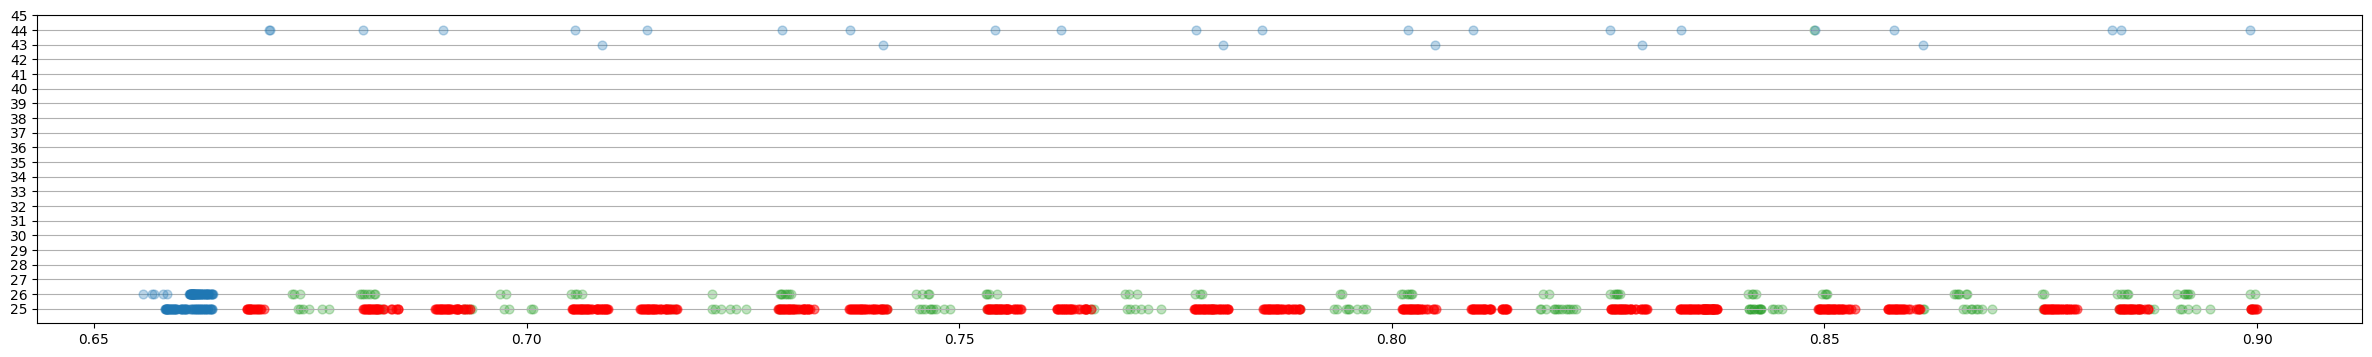

Plotting 9 allocations


/tmp/ipykernel_4504/38280641.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc_df['end_addr'] = (alloc_df['pfn'] + (2 ** alloc_df['order'])) * PAGE_SIZE


cpuid      time                           event      pfn  order  \
1622      60  0.010955  kmem:mm_page_alloc_zone_locked  5086814      0   
9955      26  0.654881  kmem:mm_page_alloc_zone_locked  5085184      9   
9956      26  0.654882  kmem:mm_page_alloc_zone_locked  5085696      9   
10014     26  0.655933              kmem:mm_page_alloc  5085184      9   
10107     26  0.657974              kmem:mm_page_alloc  5085696      9   
10822     44  0.670083              kmem:mm_page_alloc  5086753      0   
11105     44  0.670237              kmem:mm_page_alloc  5086755      0   
11470     44  0.670360              kmem:mm_page_alloc  5086732      0   
11668     44  0.670459              kmem:mm_page_alloc  5086735      0   

       cpu_node  memory_node     end_addr  
1622          0            0  20835594240  
9955          0            0  20831010816  
9956          0            0  20833107968  
10014         0            0  20831010816  
10107         0            0  20833107968  
10822         0            0  20835344384  
11105         0            0  20835352576  
11470         0            0  20835258368  
11668         0            0  20835270656

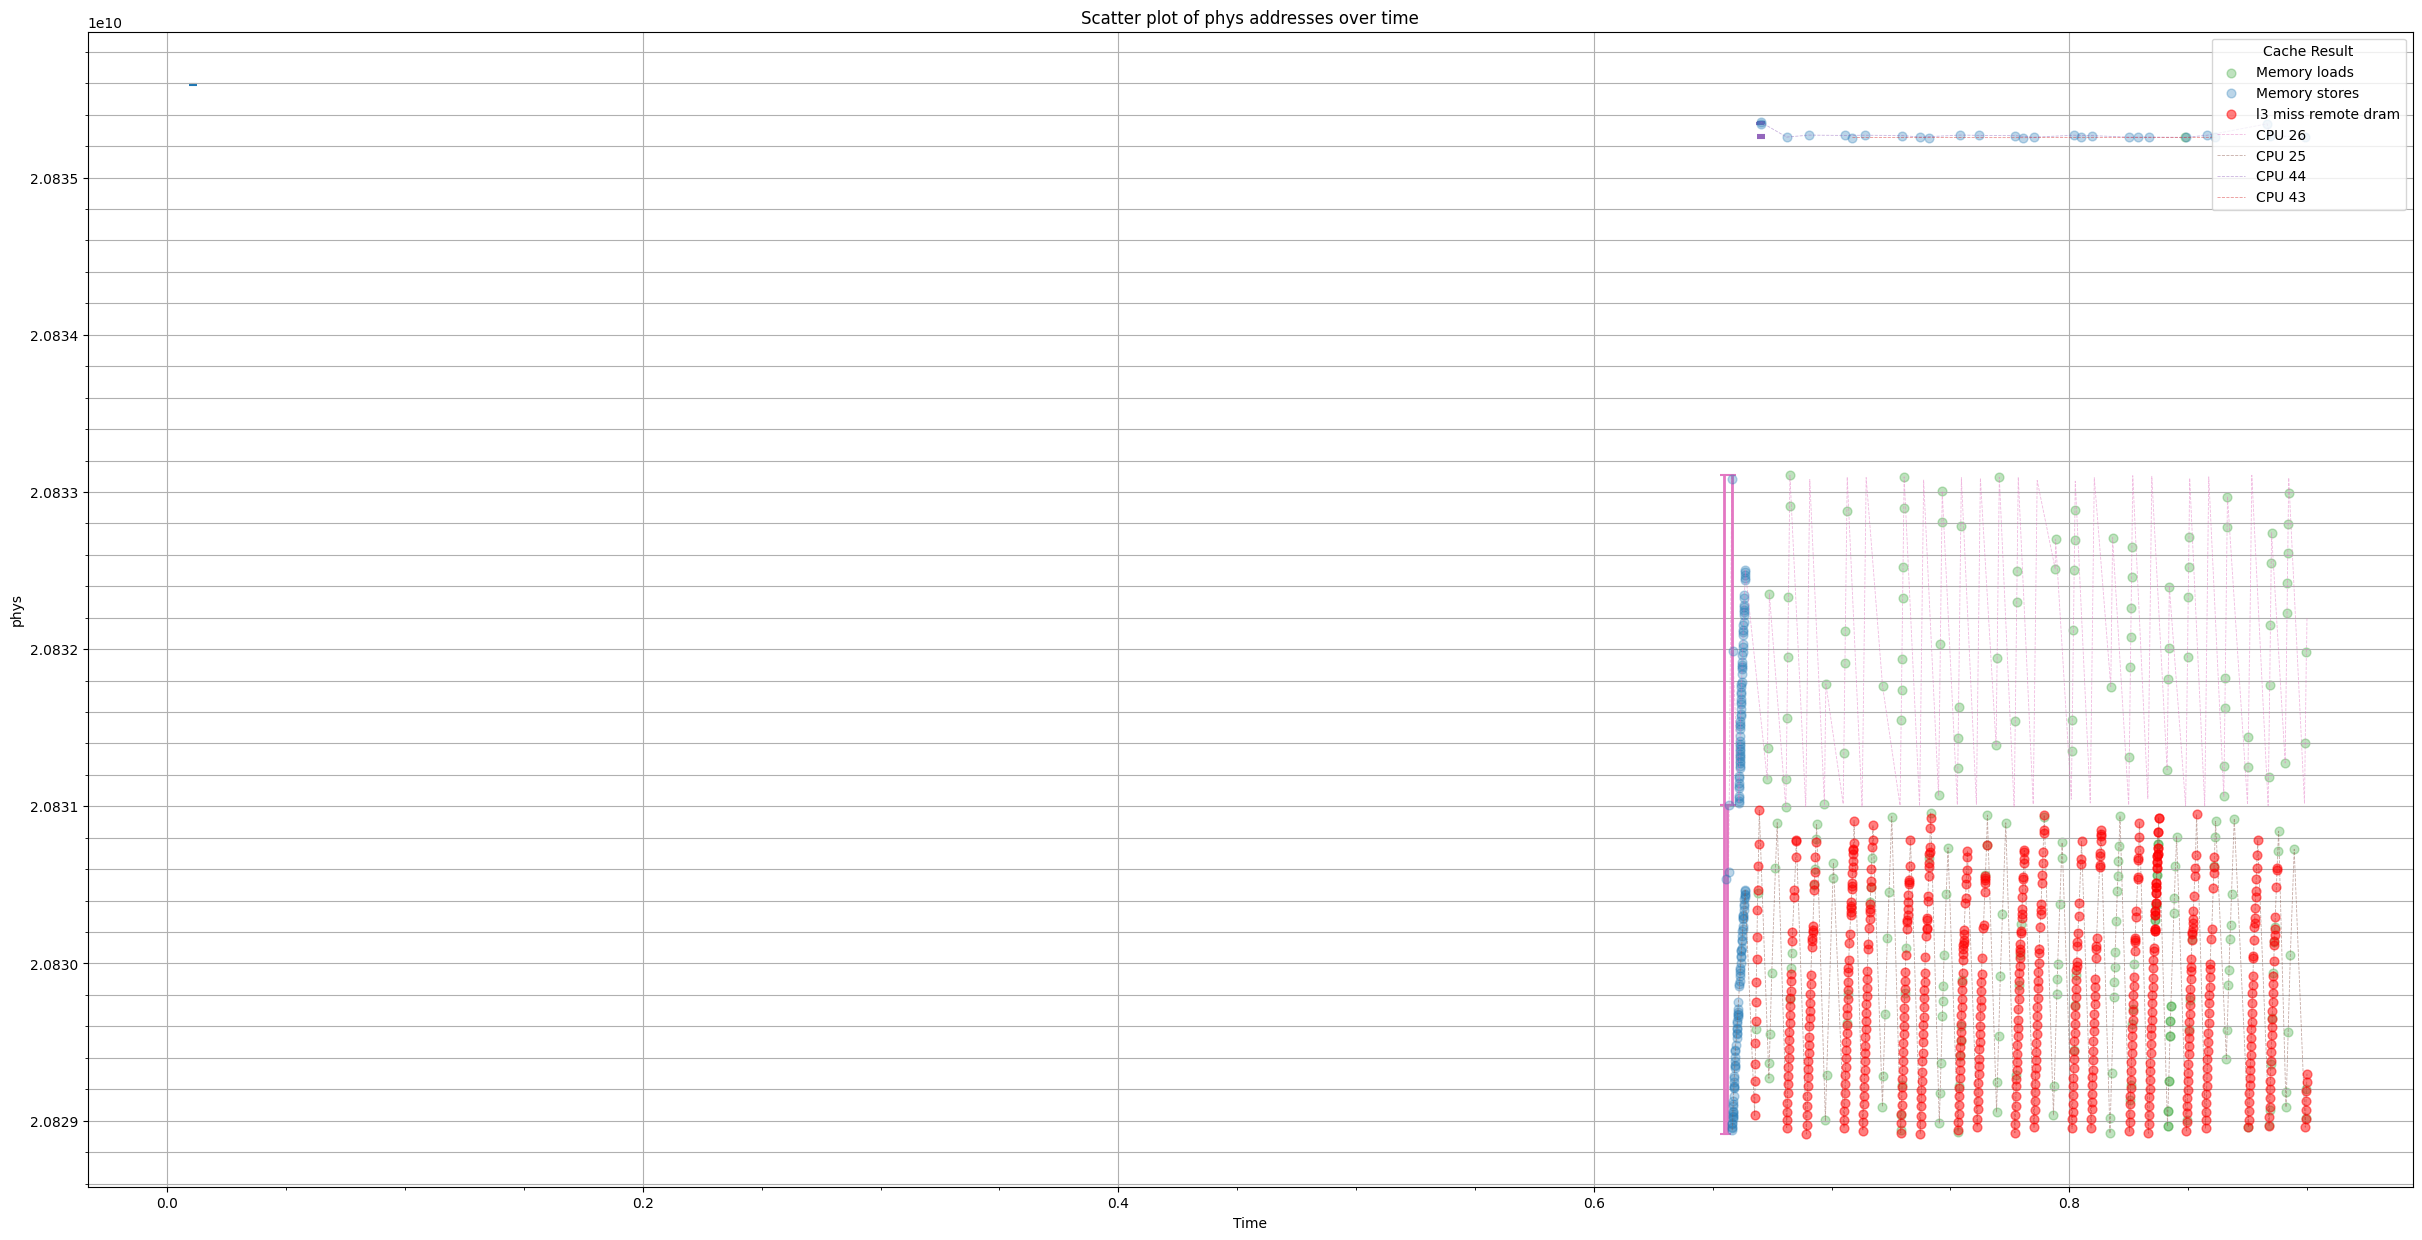

In [157]:
multiplot_phys(seq_data, curr_phys, 1300, max_t=0.9)

Address type : phys, lower bound : 20829601792, upper bound : 20831244287, size : 1642496


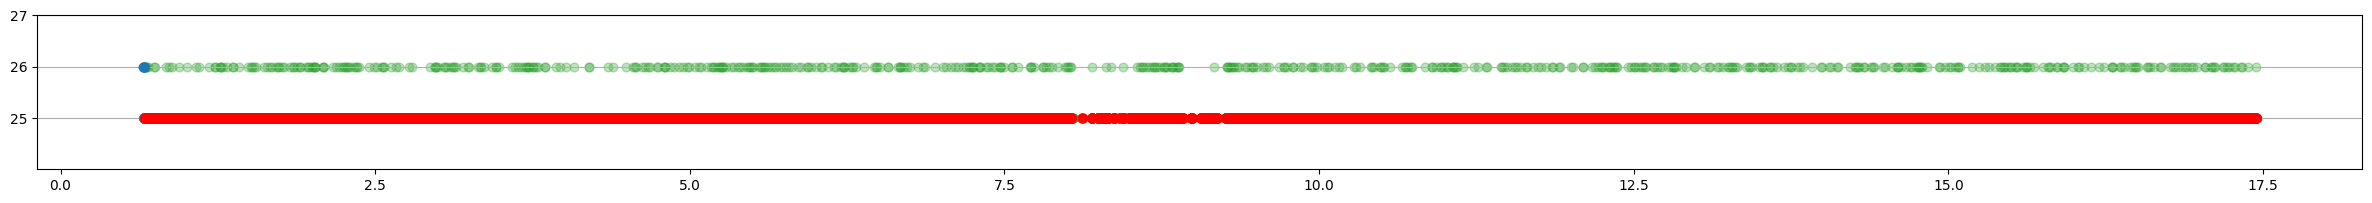

Plotting 2 allocations


cpuid      time                           event      pfn  order  \
9956      26  0.654882  kmem:mm_page_alloc_zone_locked  5085696      9   
10107     26  0.657974              kmem:mm_page_alloc  5085696      9   

       cpu_node  memory_node  
9956          0            0  
10107         0            0

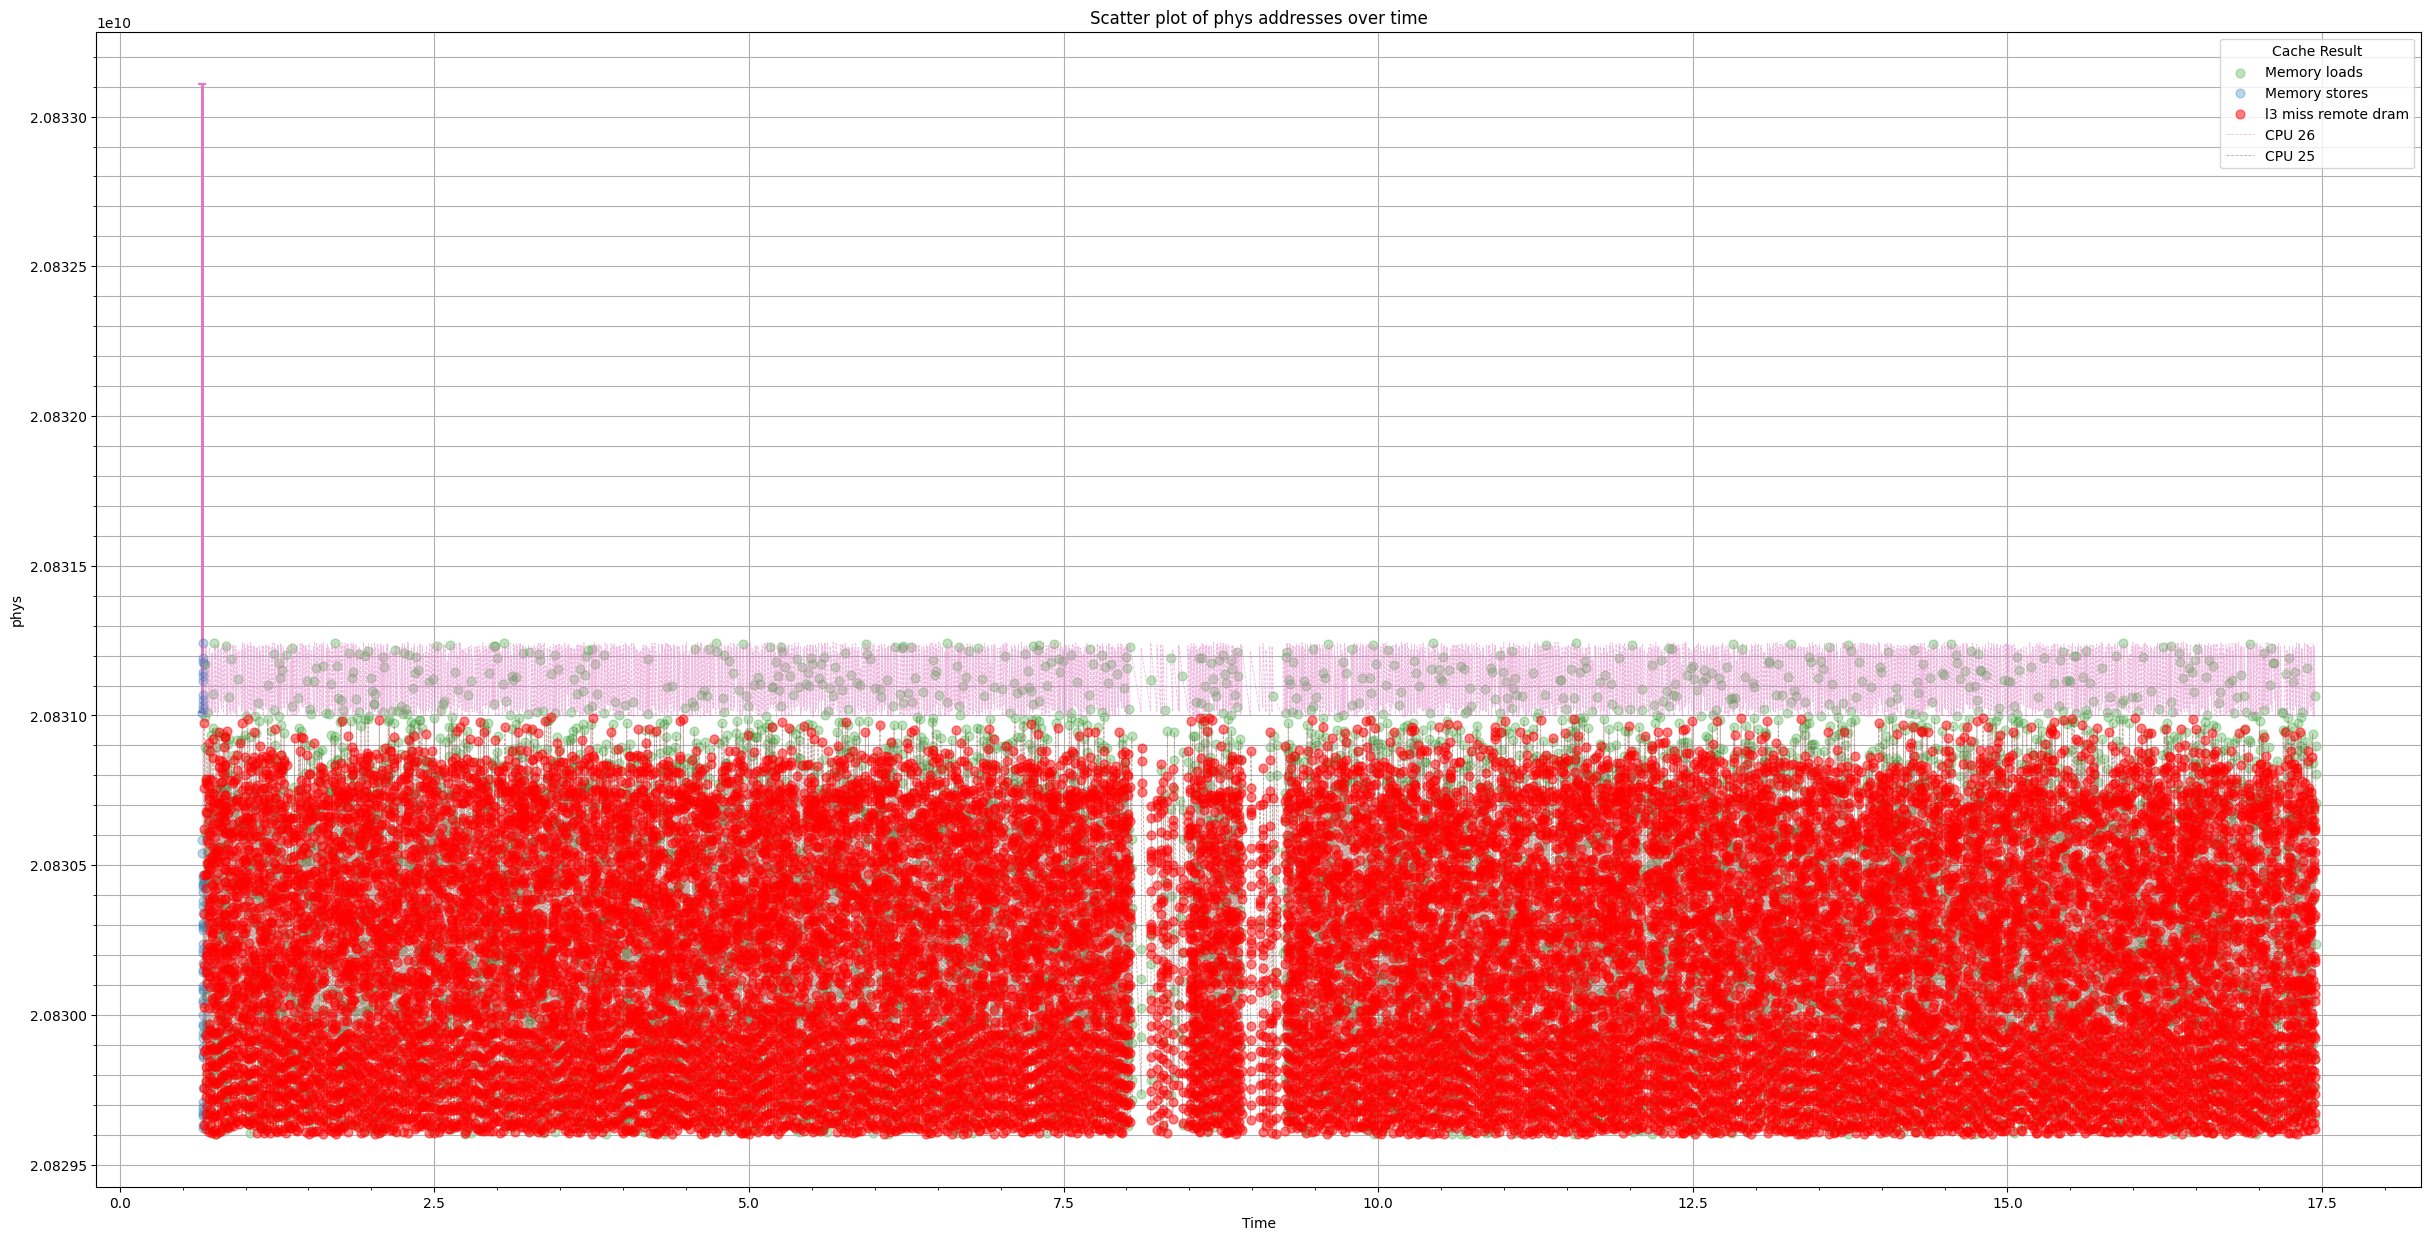

In [148]:
multiplot_phys(seq_data, curr_phys, 200)

Plotting 0 allocations


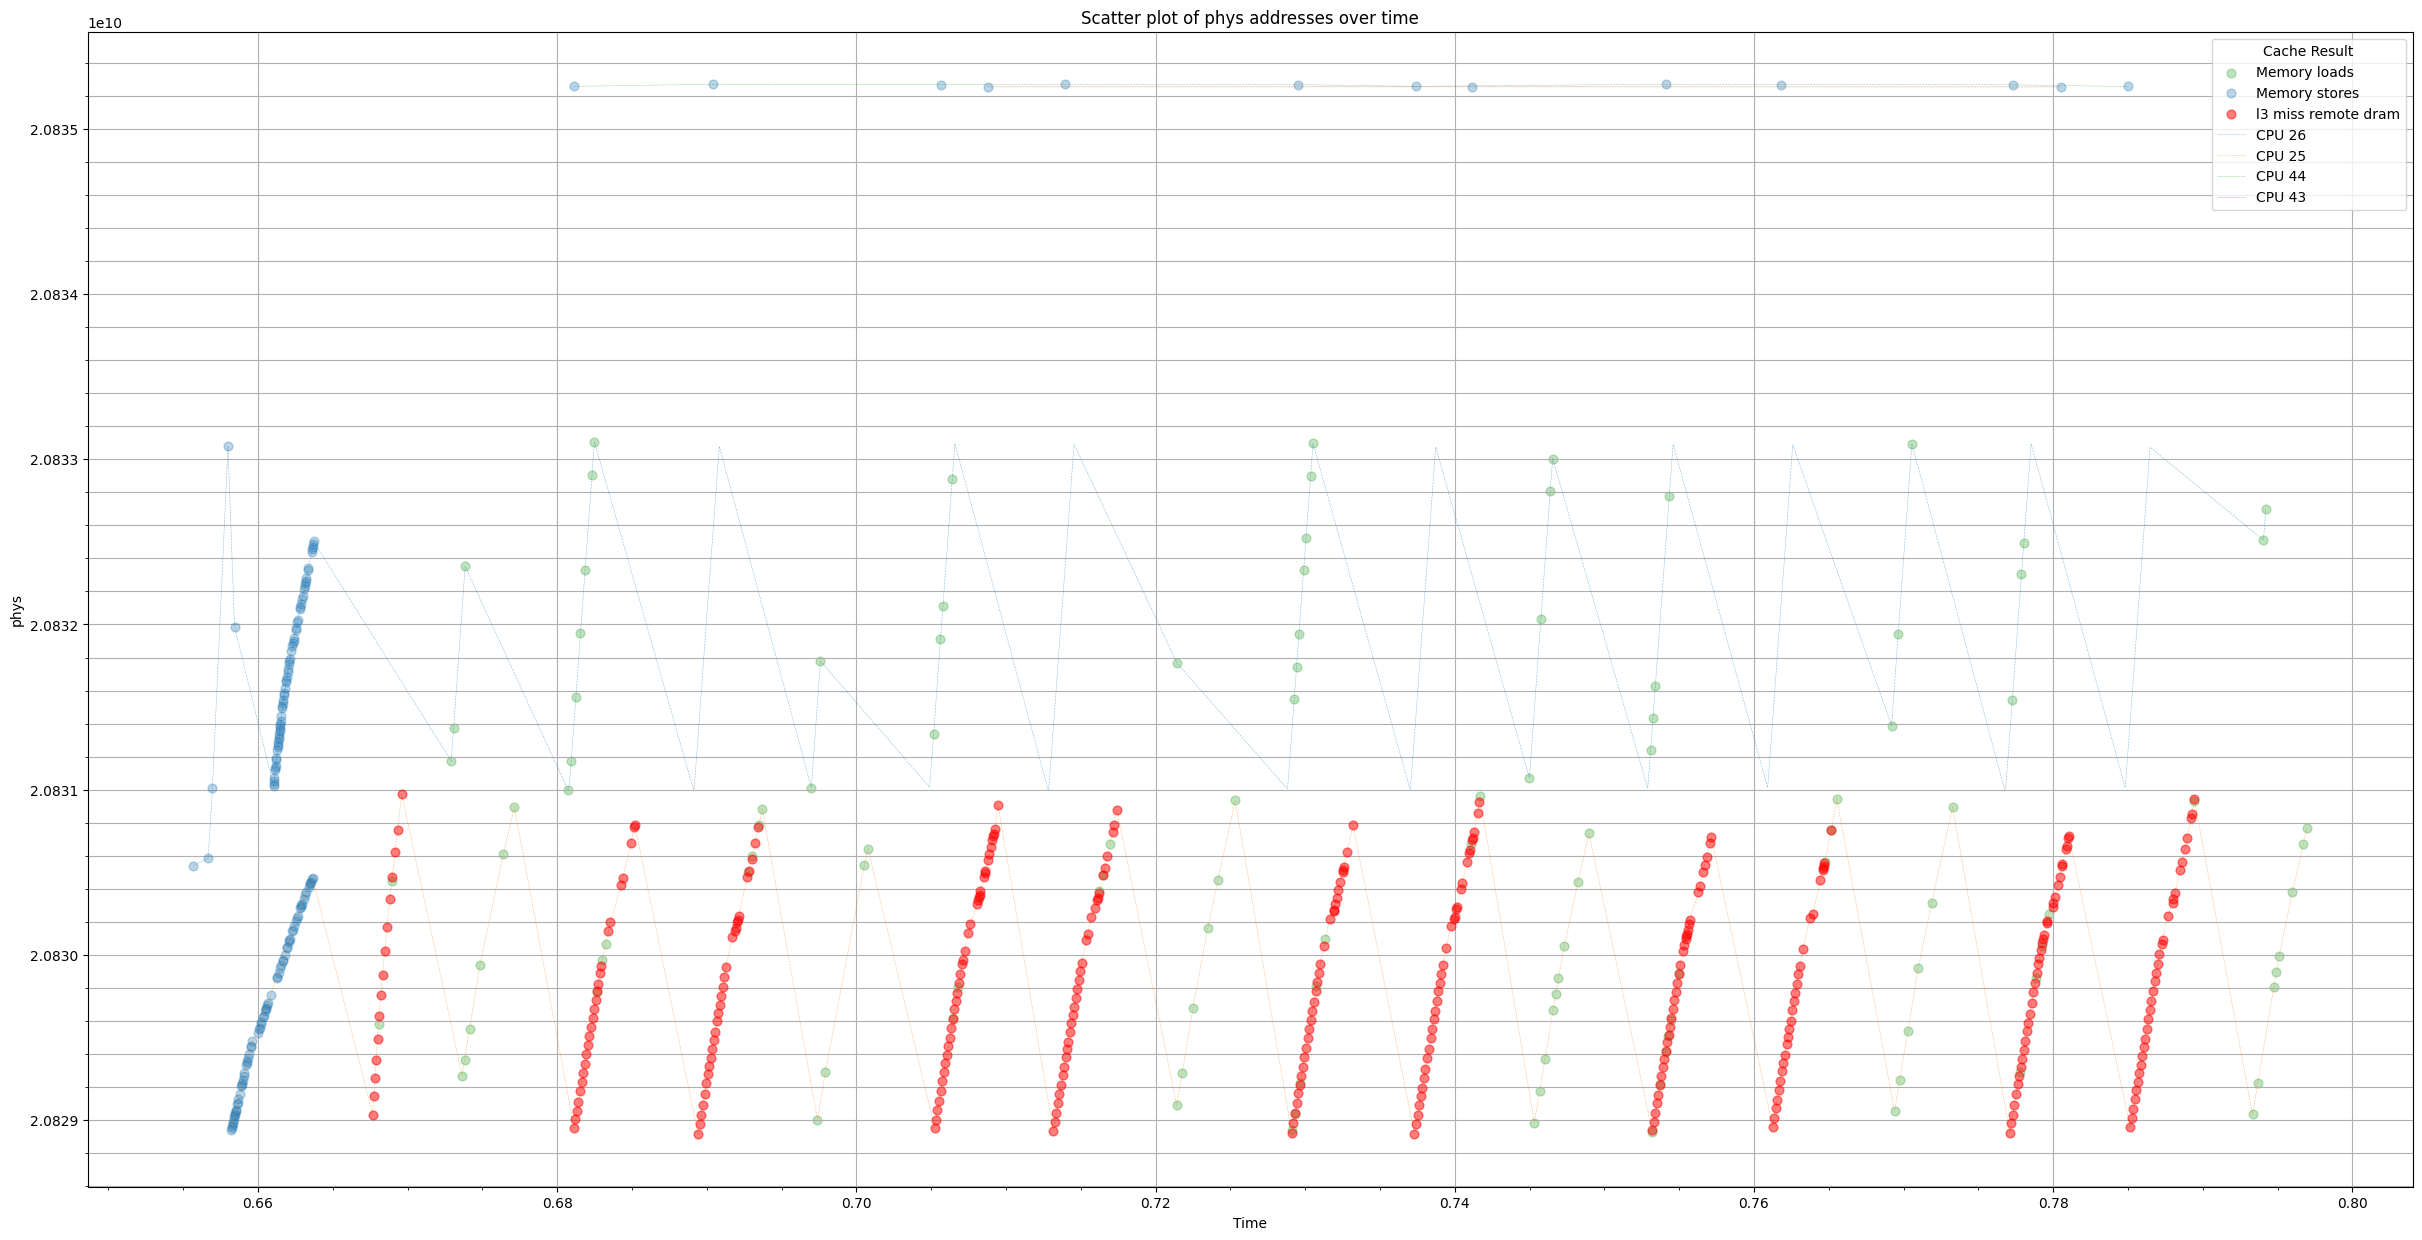

In [66]:
plotmem(filter_in_bounds(seq_data.access_df, (20825000792, 20835340287), "phys"), column="phys", min_t=0.0, max_t=0.8, w = 30, h = 15, dot_size=40)

In [ ]:
filtered_virt_df = filter_in_bounds(seq_df, (140719625732096, 140719630651391), "virt")
node_0_df = filter_in_bounds(filtered_virt_df, (None, NODE_UPPER_BOUNDARIES[0]), "phys")
node_1_df = filter_in_bounds(filtered_virt_df, (NODE_UPPER_BOUNDARIES[0], None), "phys")
plotmem(node_0_df, column="phys", cpuid=[35, 36], min_t=0.0, max_t=0.9, w = 30, h = 15, dot_size=40)
plotmem(node_0_df, column="phys", cpuid=[37], min_t=0.0, max_t=0.9, w = 30, h = 15, dot_size=40)
plotmem(node_1_df, column="phys", cpuid=[36, 37, 35], min_t=0.0, max_t=0.9, w = 30, h = 15, dot_size=40)

for i in range():
    lower_bound = None
    upper_bound = nup
    node_df = filter_in_bounds(filtered_virt_df, (lower_bound, upper_bound), "phys")

In [295]:
def multiplot_page(df: pd.DataFrame, address: int, radius = 0, min_t = None, max_t = None, w = 24, dot_size = 15):
    lower_bound, upper_bound, cpuids = plot_page_accesses(df, address, radius, min_t, max_t)
    plotmem(filter_in_bounds(df, (lower_bound, upper_bound), "phys"), column="phys", cpuid=cpuids, min_t=min_t, max_t=max_t, w = 30, h = 15, dot_size=40)
    plotmem(filter_in_bounds(df, (lower_bound, upper_bound), "phys"), column="virt", cpuid=cpuids, min_t=min_t, max_t=max_t, w = 30, h = 15, dot_size=40)

lower bound : 107163287552, upper bound : 107168206847, size : 4919296


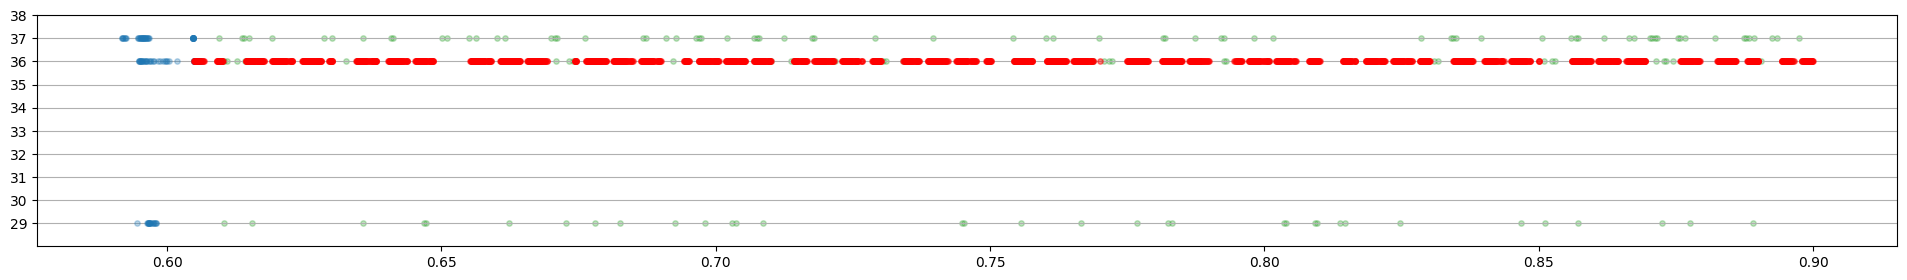

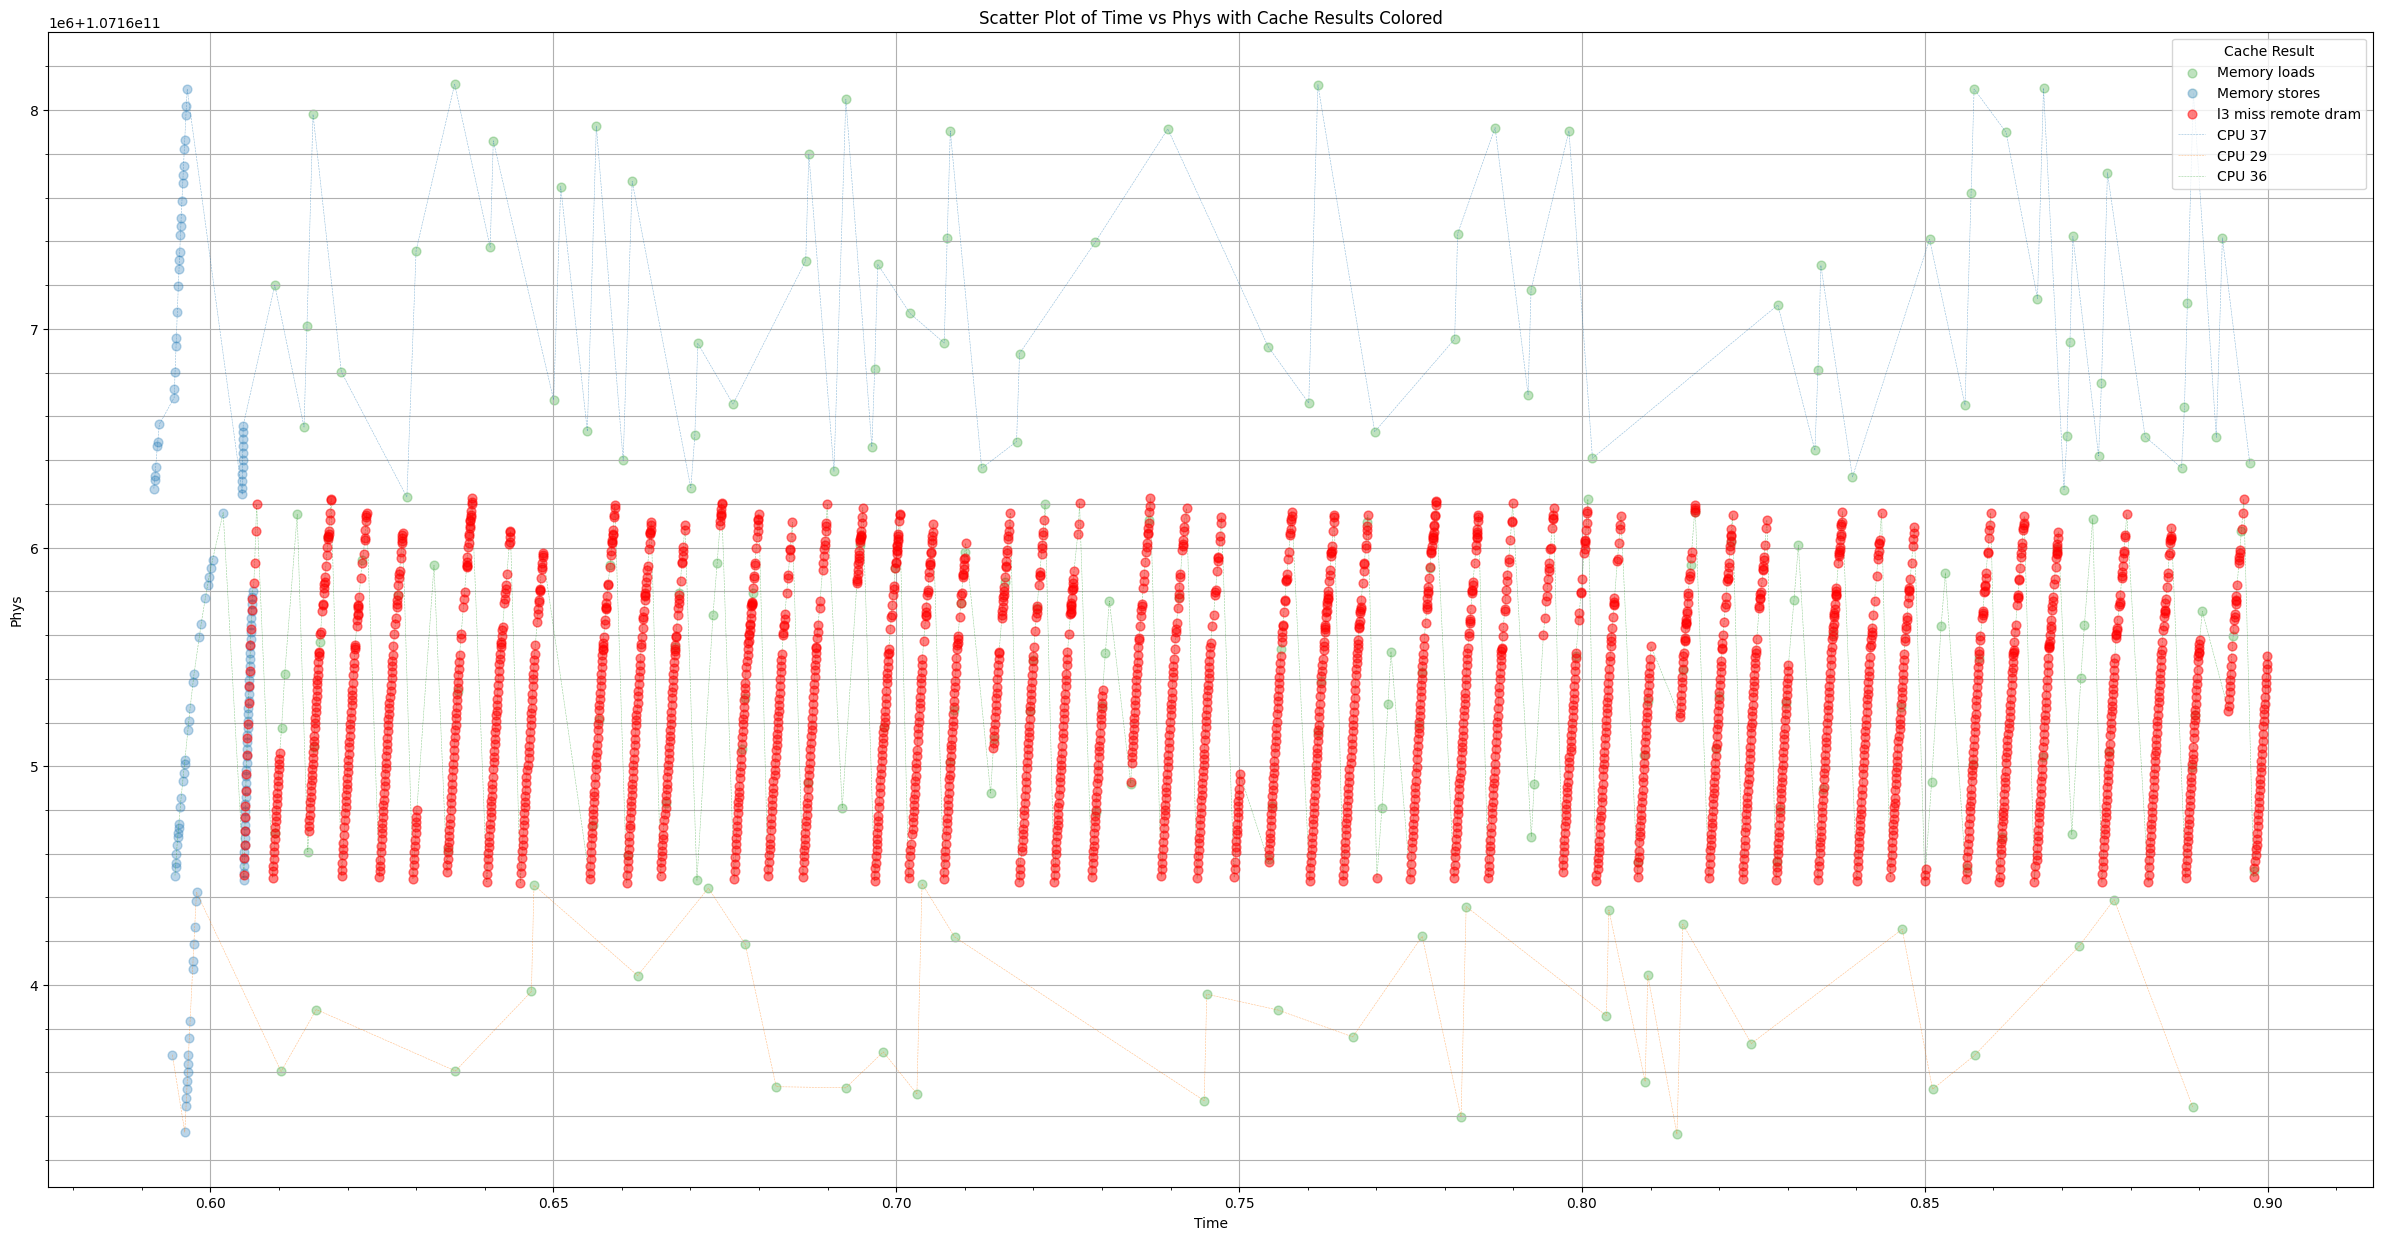

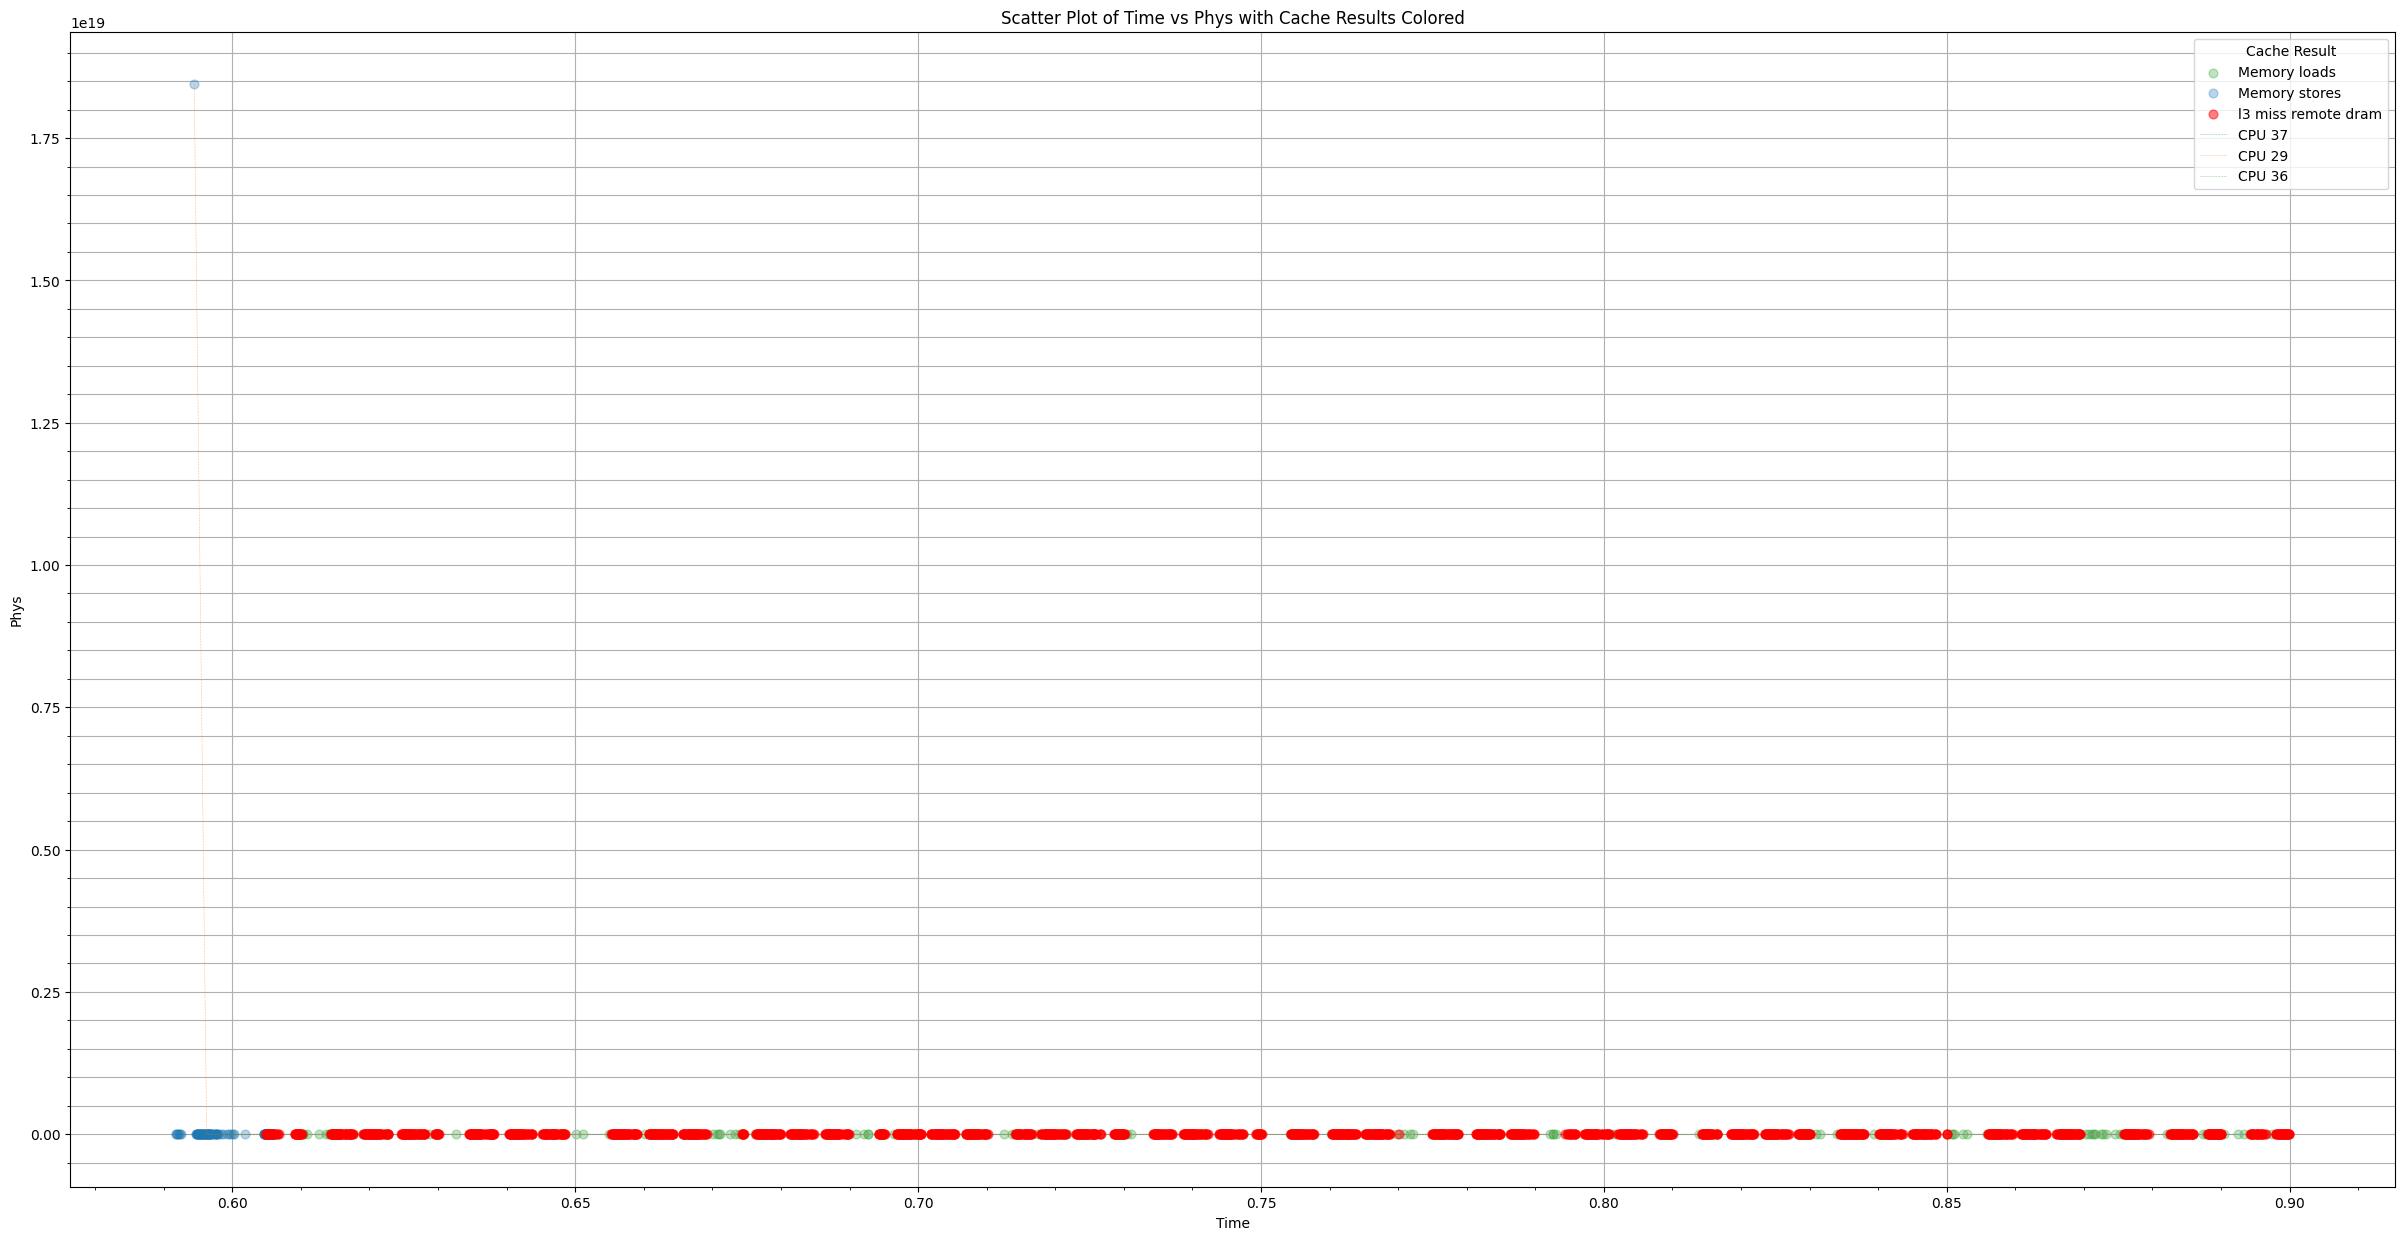

In [301]:
multiplot_page(seq_df, 107165748416, radius=600, max_t=0.9)